# Import files & functions

In [1]:
import data_utils
import training_utils
import RandomAgent
import EpsilonGreedy
import UCB
import Thompson
import FairUCB
import FairEG
import FairMAB_UCB
import FairThompson
import UCB_SRVC
import movielens_utils

from data_utils import *
from training_utils import *
from RandomAgent import *
from EpsilonGreedy import *
from UCB import *
from Thompson import *
from FairUCB import *
from FairEG import *
from FairMAB_UCB import *
from FairThompson import *
from UCB_SRVC import *
from movielens_utils import *

In [2]:
np.set_printoptions(threshold = np.inf)

# Dataset Utilities (Simulated Environment)

## An example dataset

In [3]:
example = new_user(user_id = 0, n = 1000, n_arms = 5, print_stats = True)

--- Stats for user 0 : --- 

Group representation: 
 [[1.    0.203]
 [2.    0.207]
 [3.    0.19 ]
 [4.    0.199]
 [5.    0.201]]

 --------------------- 

Proportion of liked items inside each group: 
 [[1.         0.90640394]
 [2.         0.48309179]
 [3.         0.48421053]
 [4.         0.47738693]
 [5.         0.45771144]]

 --------------------- 

Proportion of all likes allocated to each group: 
 [[1.         0.3268206 ]
 [2.         0.17761989]
 [3.         0.1634103 ]
 [4.         0.1687389 ]
 [5.         0.1634103 ]]

 --------------------- 

User data: 
 [[0 2 1]
 [0 2 1]
 [0 3 0]
 [0 1 1]
 [0 1 1]
 [0 1 1]
 [0 4 0]
 [0 5 0]
 [0 2 0]
 [0 3 1]
 [0 4 0]
 [0 1 0]
 [0 4 0]
 [0 5 0]
 [0 3 1]
 [0 2 0]
 [0 3 1]
 [0 2 0]
 [0 2 1]
 [0 3 1]
 [0 1 1]
 [0 4 1]
 [0 5 0]
 [0 5 1]
 [0 3 1]
 [0 3 0]
 [0 4 0]
 [0 5 1]
 [0 5 1]
 [0 3 0]
 [0 5 1]
 [0 1 1]
 [0 3 1]
 [0 3 0]
 [0 5 0]
 [0 5 1]
 [0 1 1]
 [0 1 0]
 [0 1 1]
 [0 1 1]
 [0 3 1]
 [0 4 0]
 [0 3 0]
 [0 2 0]
 [0 4 0]
 [0 4 0]
 [0 2 1]
 [0 2 0

As expected, this user likes all items from group 10 and none from other groups.

# Experiments

### Global parameters

In [53]:
# Size of each user dataset:
m = 2000

# Number of training rounds for each agent:
rounds = 1000

# Number of arms:
arms = 5

# Optimal agent parameters after tuning:
param_gamma      = 0.1 # Thompson Sampling
param_epsilon    = 0.1 # Epsilon-Greedy
param_multiplier = 1.0 # UCB

# 1. Baseline: Stochastic Bandits

# A. The Natural Setting (without polarisation correction)

## First User: Likes group #1, nothing else ($p_1 = 1$, $p_i = 0 \ \forall \ i > 1$)

### Generate user data

In [5]:
user = new_user(1, n = m, n_arms = arms, preferences = [1, 0, 0, 0, 0], print_stats = True)

--- Stats for user 1 : --- 

Group representation: 
 [[1.     0.215 ]
 [2.     0.1945]
 [3.     0.192 ]
 [4.     0.1975]
 [5.     0.201 ]]

 --------------------- 

Proportion of liked items inside each group: 
 [[1. 1.]
 [2. 0.]
 [3. 0.]
 [4. 0.]
 [5. 0.]]

 --------------------- 

Proportion of all likes allocated to each group: 
 [[1. 1.]
 [2. 0.]
 [3. 0.]
 [4. 0.]
 [5. 0.]]

 --------------------- 

User data: 
 [[1 3 0]
 [1 1 1]
 [1 2 0]
 [1 2 0]
 [1 2 0]
 [1 1 1]
 [1 5 0]
 [1 1 1]
 [1 1 1]
 [1 2 0]
 [1 3 0]
 [1 5 0]
 [1 1 1]
 [1 5 0]
 [1 3 0]
 [1 5 0]
 [1 4 0]
 [1 3 0]
 [1 5 0]
 [1 3 0]
 [1 2 0]
 [1 5 0]
 [1 2 0]
 [1 1 1]
 [1 5 0]
 [1 4 0]
 [1 3 0]
 [1 2 0]
 [1 3 0]
 [1 4 0]
 [1 1 1]
 [1 4 0]
 [1 1 1]
 [1 5 0]
 [1 1 1]
 [1 4 0]
 [1 2 0]
 [1 2 0]
 [1 2 0]
 [1 5 0]
 [1 1 1]
 [1 5 0]
 [1 1 1]
 [1 4 0]
 [1 3 0]
 [1 2 0]
 [1 5 0]
 [1 1 1]
 [1 4 0]
 [1 5 0]
 [1 3 0]
 [1 4 0]
 [1 2 0]
 [1 3 0]
 [1 3 0]
 [1 1 1]
 [1 2 0]
 [1 4 0]
 [1 5 0]
 [1 4 0]
 [1 1 1]
 [1 3 0]
 [1 4 0]
 [1 2 0]
 [1 

In [6]:
user_neutral = new_user(21, n = m, n_arms = arms, preferences = [0.5, 0.5, 0.5, 0.5, 0.5], print_stats = True)

--- Stats for user 21 : --- 

Group representation: 
 [[1.     0.1855]
 [2.     0.206 ]
 [3.     0.207 ]
 [4.     0.199 ]
 [5.     0.2025]]

 --------------------- 

Proportion of liked items inside each group: 
 [[1.         0.52830189]
 [2.         0.46116505]
 [3.         0.52415459]
 [4.         0.5201005 ]
 [5.         0.52098765]]

 --------------------- 

Proportion of all likes allocated to each group: 
 [[1.         0.19196866]
 [2.         0.18609207]
 [3.         0.21253673]
 [4.         0.20274241]
 [5.         0.20666014]]

 --------------------- 

User data: 
 [[21  5  0]
 [21  5  0]
 [21  5  1]
 [21  2  1]
 [21  4  0]
 [21  2  1]
 [21  2  0]
 [21  1  0]
 [21  1  0]
 [21  3  0]
 [21  5  1]
 [21  3  0]
 [21  2  0]
 [21  4  0]
 [21  3  1]
 [21  5  0]
 [21  2  0]
 [21  3  1]
 [21  3  0]
 [21  4  1]
 [21  2  0]
 [21  3  0]
 [21  1  0]
 [21  1  0]
 [21  4  1]
 [21  1  0]
 [21  5  1]
 [21  4  1]
 [21  2  0]
 [21  2  0]
 [21  5  0]
 [21  4  1]
 [21  3  0]
 [21  5  1]
 [21  4  1]

### Agents initialisation and training

In [7]:
# p = 0.1
# for _ in range(100):
#     print(p)
#     ucb = UCB(bonus_multiplier = p)
#     history_ucb = train(user,  ucb, steps = rounds)
#     score(history_ucb)
#     p += 0.1

In [54]:
# Initialize agents
rdm  = RandomBandit()
eps  = EpsilonGreedy(epsilon = param_epsilon)
ucb  = UCB(bonus_multiplier = param_multiplier)
th   = Thompson()

# Train agents
history_rdm   = train(user,  rdm, steps = rounds)
history_eps   = train(user,  eps, steps = rounds)
history_ucb   = train(user,  ucb, steps = rounds)
history_th    = train(user,   th, steps = rounds)

Successfully trained Random Agent.
Successfully trained Epsilon Greedy Agent.
Successfully trained UCB Agent.
Successfully trained Thompson Sampling Agent.


### Random Agent

Group frequencies                        : [0.169 0.2   0.211 0.225 0.195]
Max gap between group frequencies        : 0.055999999999999994
Cumulative gap between group frequencies : 0.008659999999999996
Total reward                             : 487/1000
Performance ratio                        : 56.235565819861456


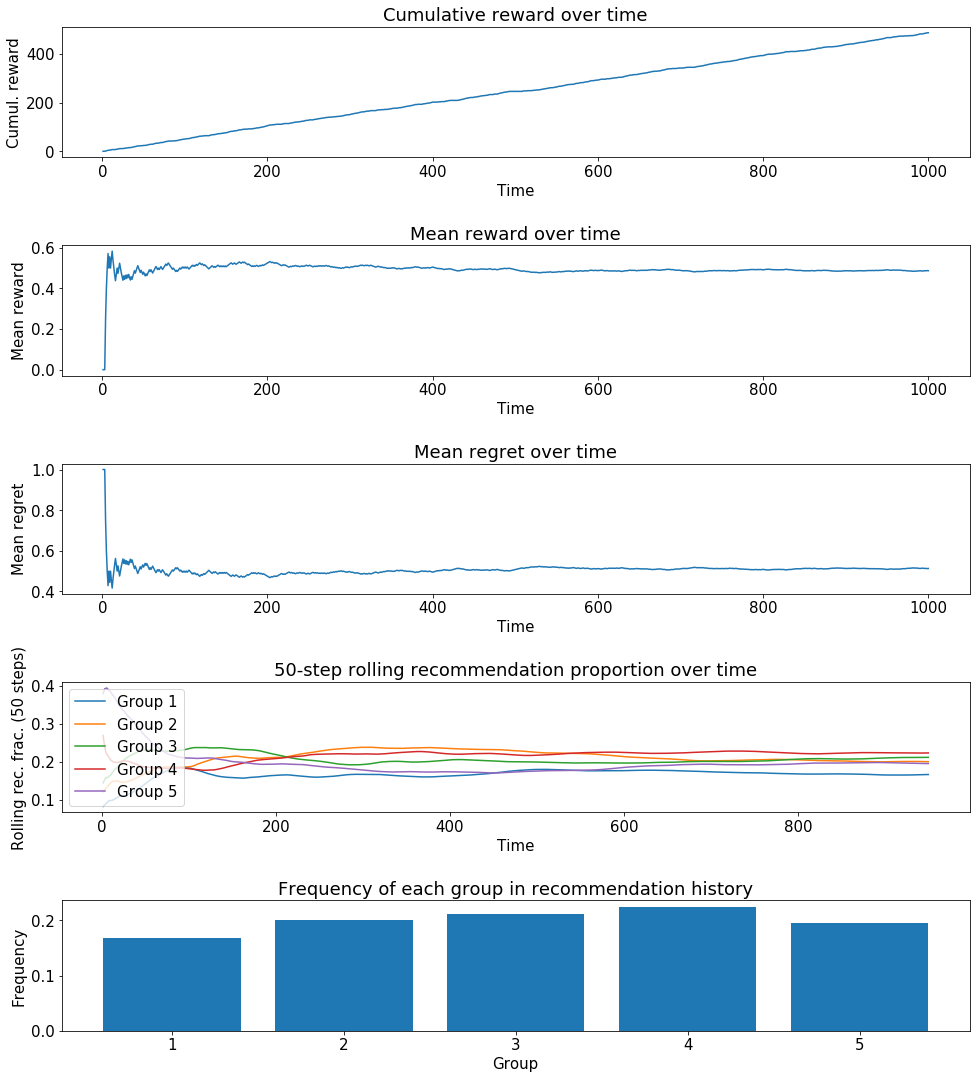

(0.055999999999999994, 487, 0.008659999999999996, 56.235565819861456)

In [55]:
score(history_rdm)

### $\epsilon$-Greedy

Group frequencies                        : [0.921 0.027 0.017 0.017 0.018]
Max gap between group frequencies        : 0.904
Cumulative gap between group frequencies : 3.2493600000000016
Total reward                             : 921/1000
Performance ratio                        : 0.2834404313464804


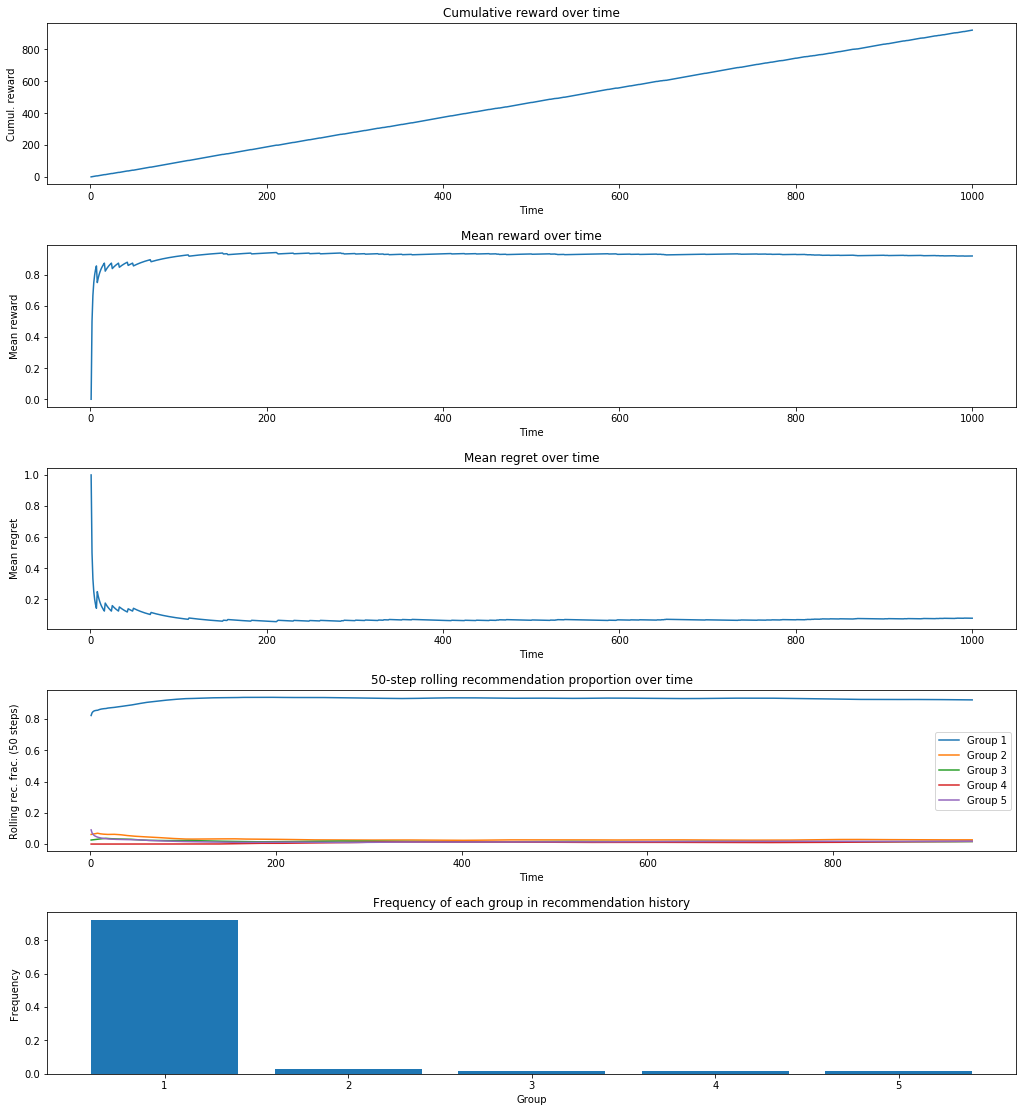

(0.904, 921, 3.2493600000000016, 0.2834404313464804)

In [10]:
score(history_eps)

### UCB

Group frequencies                        : [0.956 0.011 0.011 0.011 0.011]
Max gap between group frequencies        : 0.945
Cumulative gap between group frequencies : 3.5721
Total reward                             : 956/1000
Performance ratio                        : 0.2676296856191036


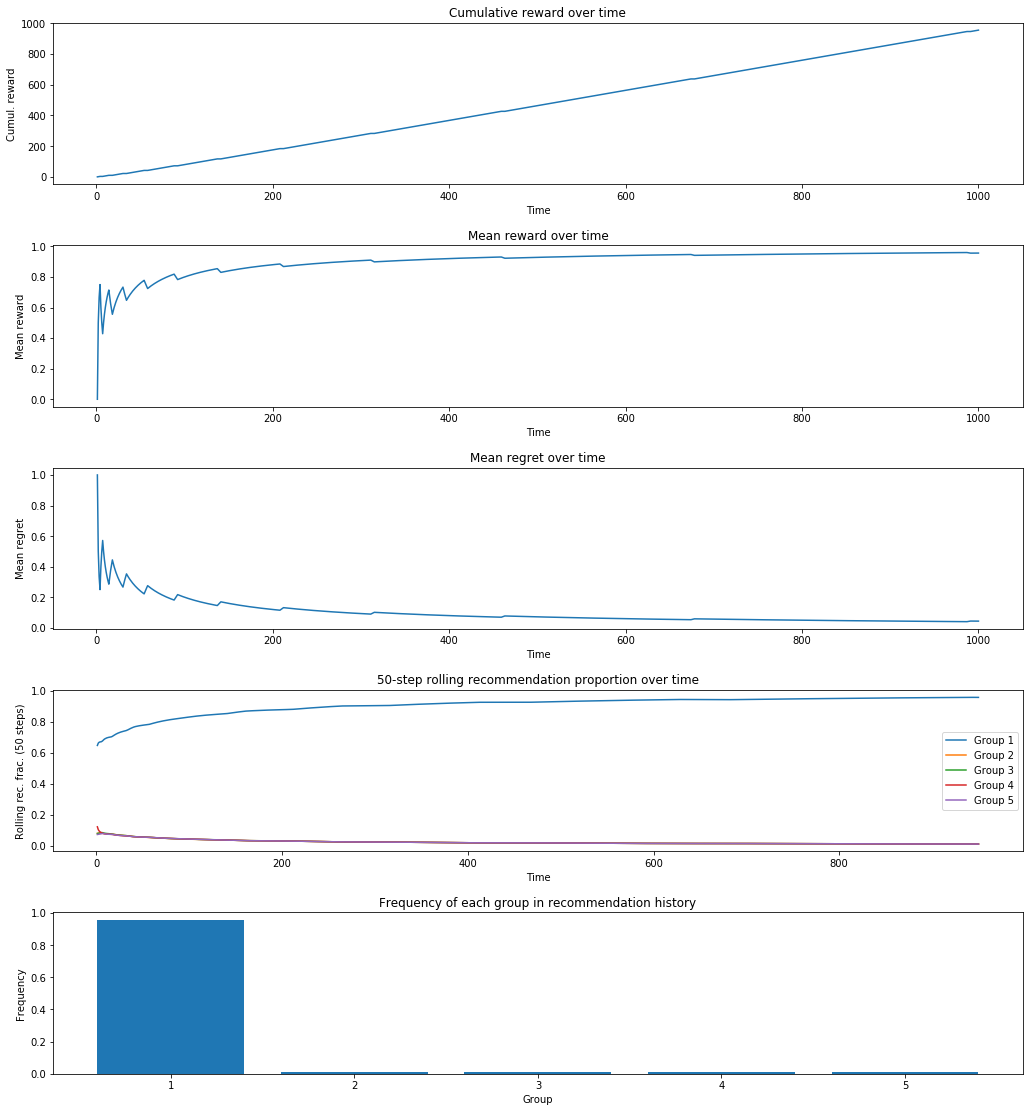

(0.945, 956, 3.5721, 0.2676296856191036)

In [11]:
score(history_ucb)

### Thompson Sampling

Group frequencies                        : [0.995 0.001 0.001 0.002 0.001]
Max gap between group frequencies        : 0.994
Cumulative gap between group frequencies : 3.9501600000000003
Total reward                             : 995/1000
Performance ratio                        : 0.2518885310974745


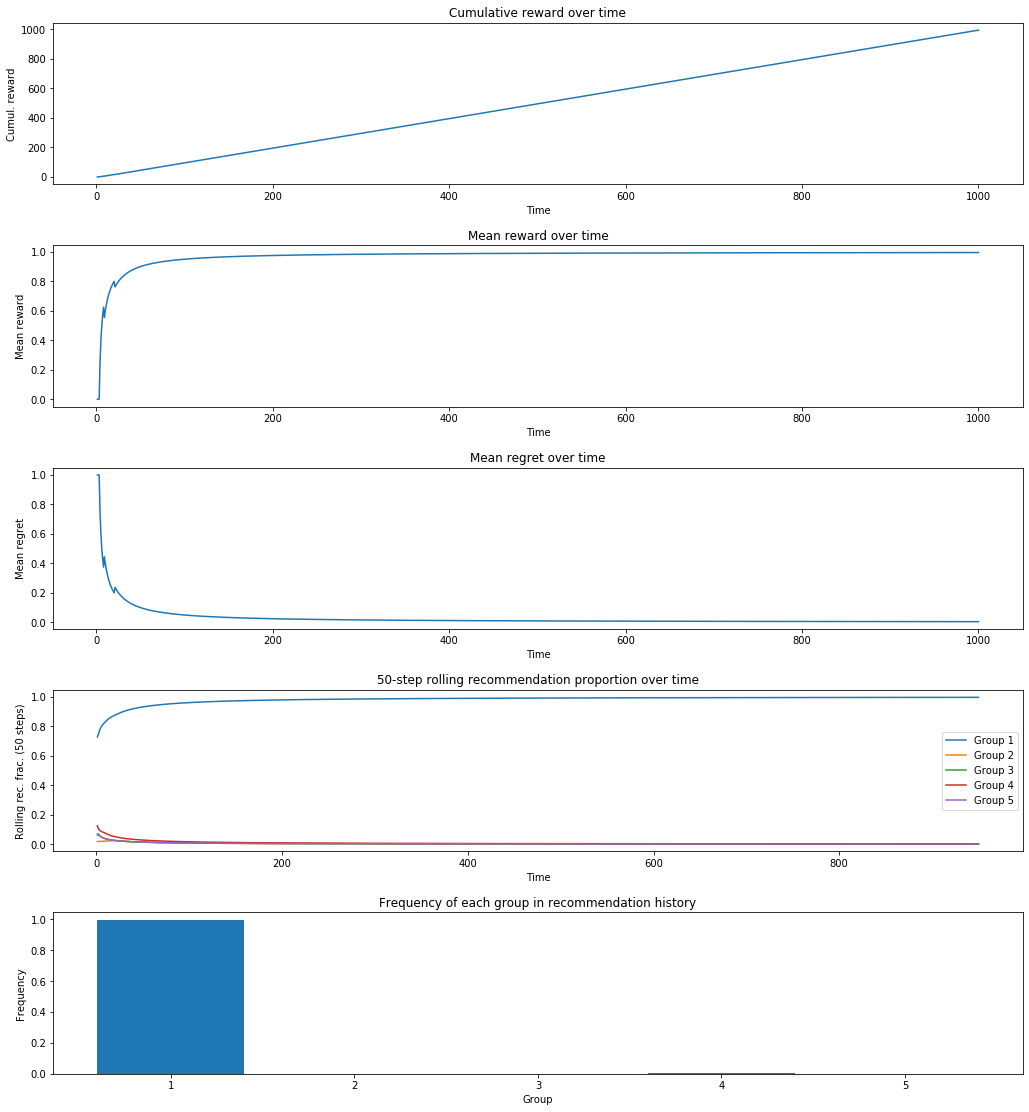

(0.994, 995, 3.9501600000000003, 0.2518885310974745)

In [12]:
score(history_th)

## Second User: prefers groups #1 and #2 ($p_1 = p_2 = 0.9$, $p_i = 0.5 \ \forall \ i > 2$)

### Generate user data

In [13]:
user2 = new_user(2, n = m, n_arms = arms, preferences = [0.9, 0.9, 0.5, 0.5, 0.5], print_stats = True)

--- Stats for user 2 : --- 

Group representation: 
 [[1.     0.1965]
 [2.     0.217 ]
 [3.     0.191 ]
 [4.     0.199 ]
 [5.     0.1965]]

 --------------------- 

Proportion of liked items inside each group: 
 [[1.         0.8956743 ]
 [2.         0.89400922]
 [3.         0.51832461]
 [4.         0.48994975]
 [5.         0.48854962]]

 --------------------- 

Proportion of all likes allocated to each group: 
 [[1.         0.26566038]
 [2.         0.29283019]
 [3.         0.14943396]
 [4.         0.14716981]
 [5.         0.14490566]]

 --------------------- 

User data: 
 [[2 4 1]
 [2 1 1]
 [2 2 1]
 [2 3 1]
 [2 4 0]
 [2 3 1]
 [2 5 1]
 [2 1 1]
 [2 2 1]
 [2 5 0]
 [2 2 1]
 [2 4 0]
 [2 2 1]
 [2 4 1]
 [2 2 1]
 [2 3 0]
 [2 2 1]
 [2 2 0]
 [2 2 1]
 [2 3 1]
 [2 5 0]
 [2 1 1]
 [2 3 0]
 [2 3 1]
 [2 3 0]
 [2 3 0]
 [2 3 1]
 [2 1 1]
 [2 4 1]
 [2 5 1]
 [2 4 0]
 [2 5 1]
 [2 4 1]
 [2 1 1]
 [2 3 1]
 [2 2 1]
 [2 4 0]
 [2 1 1]
 [2 2 1]
 [2 2 1]
 [2 4 1]
 [2 2 1]
 [2 2 1]
 [2 5 0]
 [2 2 1]
 [2 4 1]
 [2 1 

### Agents initialisation and training

In [14]:
# Initialize agents
eps2   = EpsilonGreedy(epsilon = param_epsilon)
ucb2   = UCB(bonus_multiplier = param_multiplier)
th2    = Thompson()

# Train agents
history_rdm2   = train(user2,    rdm, steps = rounds)
history_eps2   = train(user2,   eps2, steps = rounds)
history_ucb2   = train(user2,   ucb2, steps = rounds)
history_th2    = train(user2,    th2, steps = rounds)

Successfully trained Random Agent.
Successfully trained Epsilon Greedy Agent.
Successfully trained UCB Agent.
Successfully trained Thompson Sampling Agent.


### Random Agent

Group frequencies                        : [0.194 0.196 0.212 0.193 0.205]
Max gap between group frequencies        : 0.01899999999999999
Cumulative gap between group frequencies : 0.0013499999999999975
Total reward                             : 667/1000
Performance ratio                        : 494.07407407407504


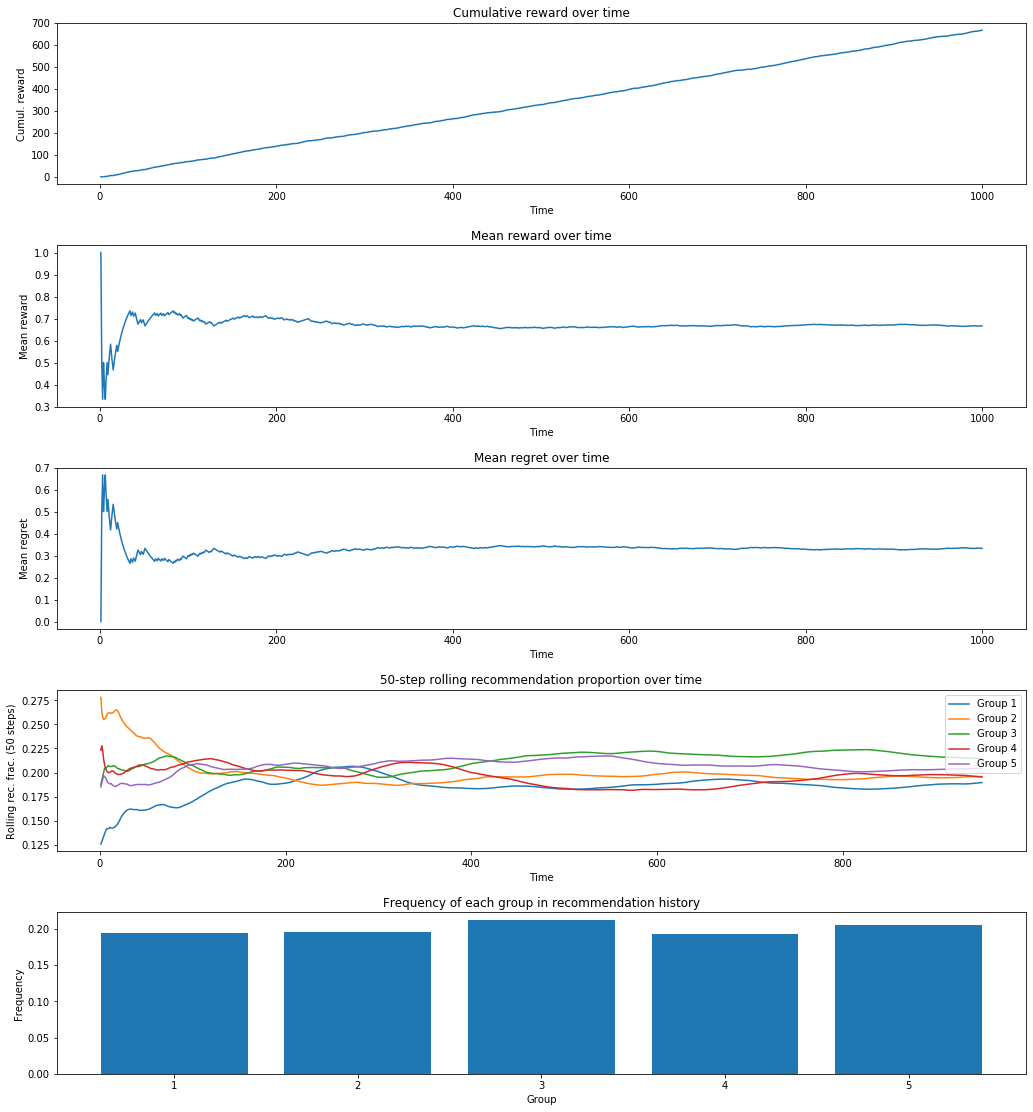

(0.01899999999999999, 667, 0.0013499999999999975, 494.07407407407504)

In [15]:
score(history_rdm2)

### $\epsilon$-Greedy

Group frequencies                        : [0.032 0.901 0.019 0.028 0.02 ]
Max gap between group frequencies        : 0.882
Cumulative gap between group frequencies : 3.0718500000000004
Total reward                             : 880/1000
Performance ratio                        : 0.28647232123964383


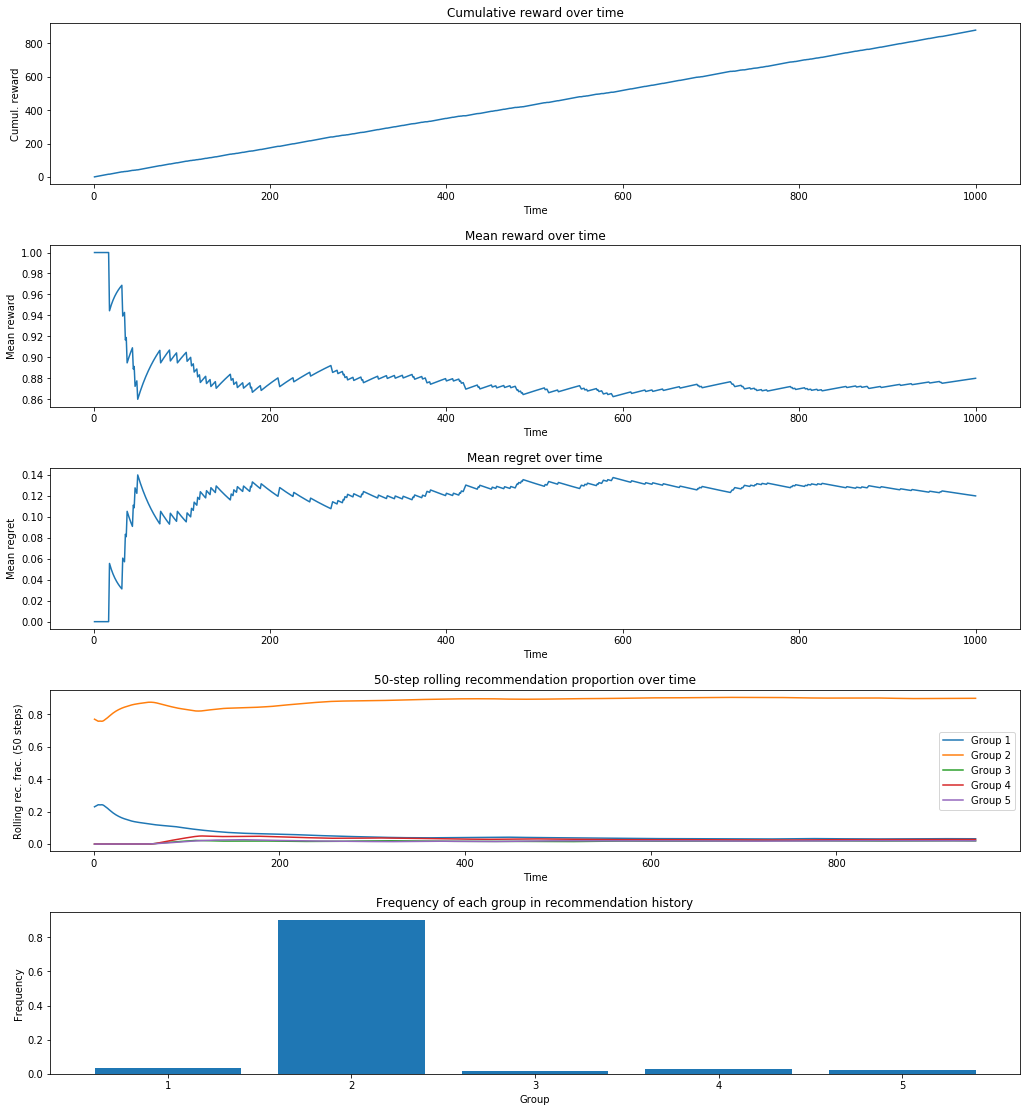

(0.882, 880, 3.0718500000000004, 0.28647232123964383)

In [16]:
score(history_eps2)

### UCB

Group frequencies                        : [0.38  0.514 0.023 0.049 0.034]
Max gap between group frequencies        : 0.491
Cumulative gap between group frequencies : 1.0634099999999997
Total reward                             : 838/1000
Performance ratio                        : 0.7880309570156385


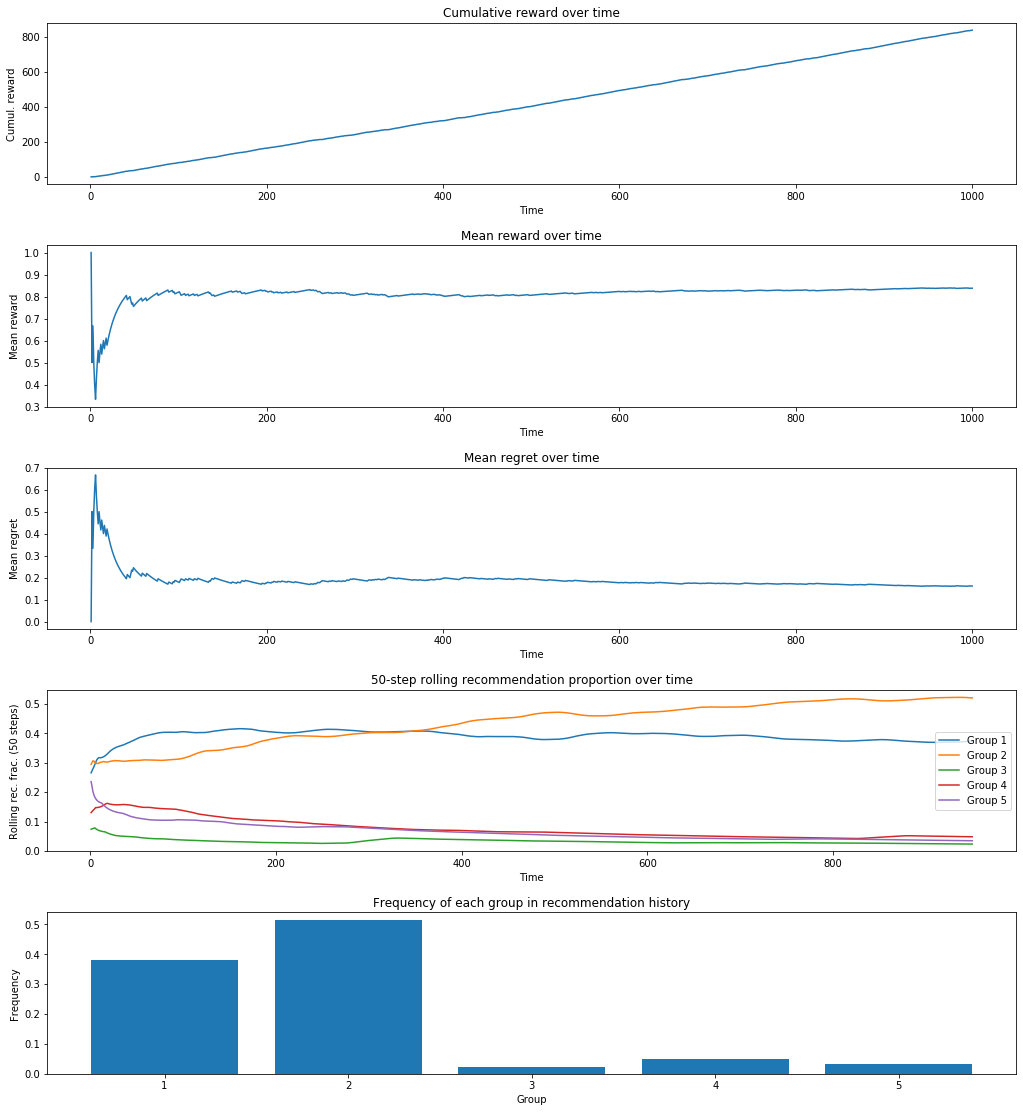

(0.491, 838, 1.0634099999999997, 0.7880309570156385)

In [17]:
score(history_ucb2)

### Thompson Sampling

Group frequencies                        : [0.657 0.326 0.005 0.002 0.01 ]
Max gap between group frequencies        : 0.655
Cumulative gap between group frequencies : 1.69027
Total reward                             : 906/1000
Performance ratio                        : 0.5360090399758618


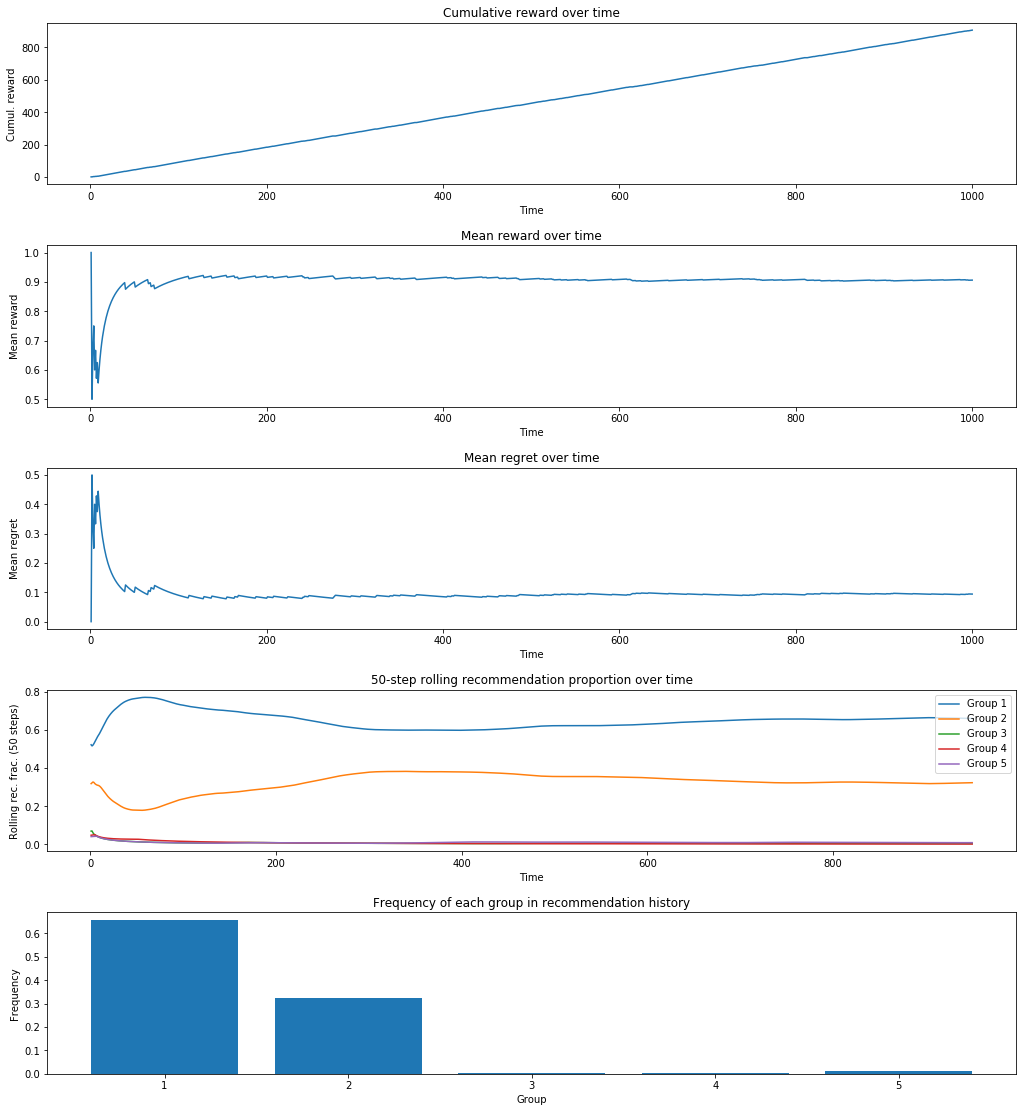

(0.655, 906, 1.69027, 0.5360090399758618)

In [18]:
score(history_th2)

# B. The Depolarised Setting

## FairEG

Successfully trained Fair Epsilon Greedy agent.
Group frequencies                        : [0.112 0.587 0.1   0.101 0.1  ]
Max gap between group frequencies        : 0.487
Cumulative gap between group frequencies : 0.93657
Total reward                             : 778/1000
Performance ratio                        : 0.8306907118528246


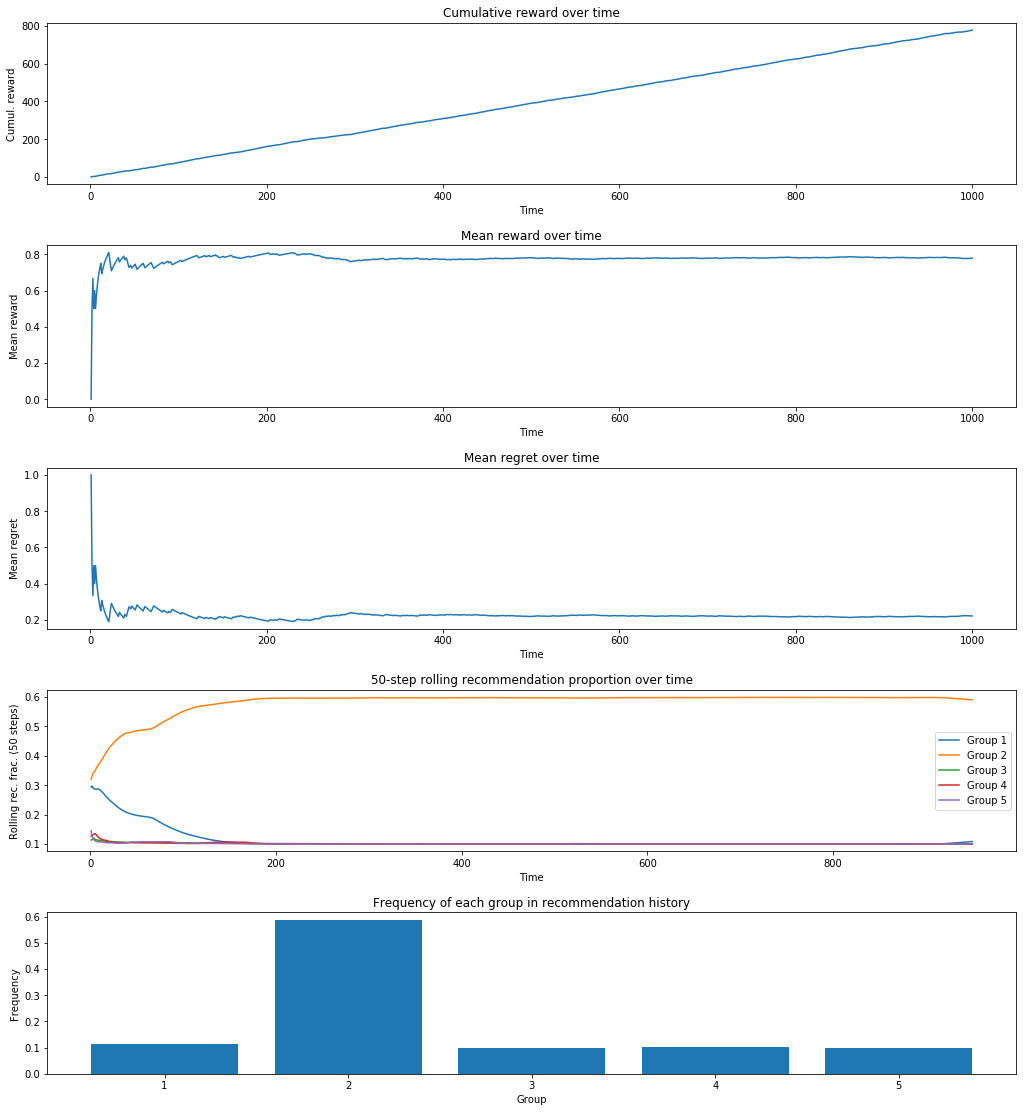

(0.487, 778, 0.93657, 0.8306907118528246)

In [19]:
# Initialize agent
fairEG = FairEG()

# Train agent
fairEG_history = train(user2, fairEG, steps = rounds)

# Plot results
score(fairEG_history)

## FairUCB

Successfully trained Fair UCB agent.
Group frequencies                        : [0.365 0.338 0.099 0.099 0.099]
Max gap between group frequencies        : 0.266
Cumulative gap between group frequencies : 0.3843600000000001
Total reward                             : 781/1000
Performance ratio                        : 2.0319492142782805


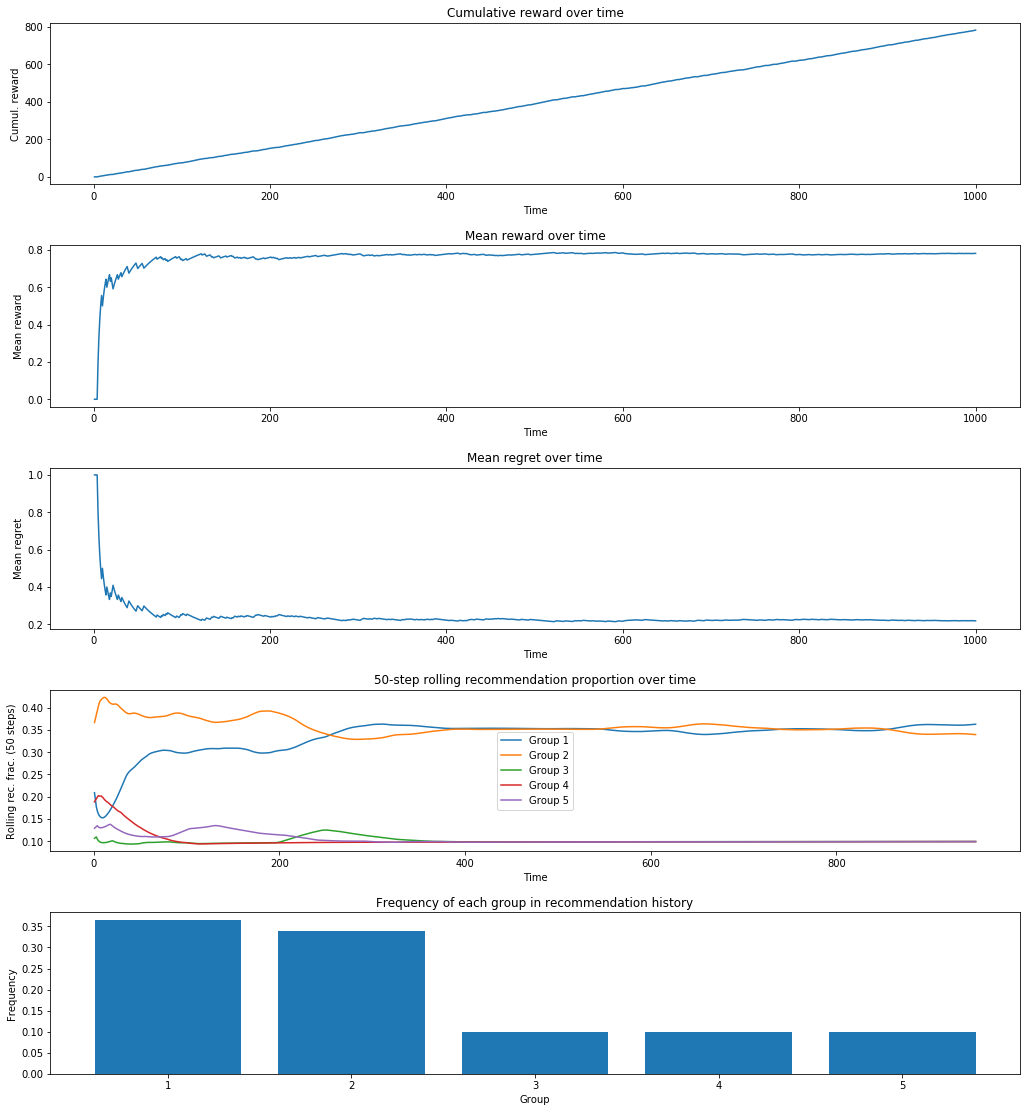

(0.266, 781, 0.3843600000000001, 2.0319492142782805)

In [20]:
# Initialize agent
fMAB_UCB = FairMAB_UCB()

# Train agent
fMAB_UCB_history = train(user2, fMAB_UCB, steps = rounds)

# Plot results
score(fMAB_UCB_history)

## FairThompson

Successfully trained Fair Thompson Sampling agent.
Group frequencies                        : [0.531 0.169 0.1   0.1   0.1  ]
Max gap between group frequencies        : 0.43100000000000005
Cumulative gap between group frequencies : 0.7026100000000002
Total reward                             : 794/1000
Performance ratio                        : 1.1300721595195056


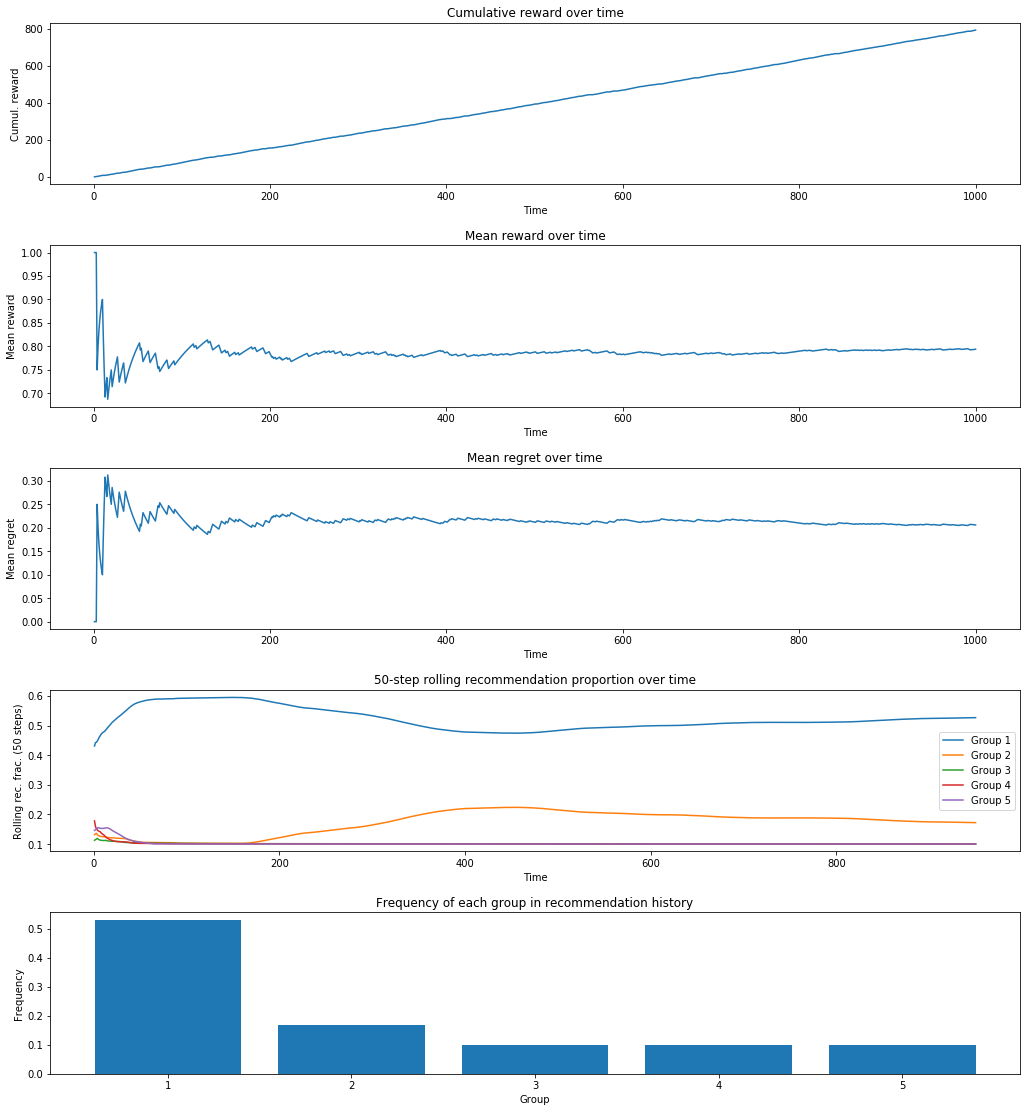

(0.43100000000000005, 794, 0.7026100000000002, 1.1300721595195056)

In [21]:
# Initialize agent
fairThompson = FairThompson()

# Train agent
fairThompson_history = train(user2, fairThompson, steps = rounds)

# Plot results
score(fairThompson_history)

## UCB-SRVC

In [22]:
user3 = new_user(3, n = m, n_arms = arms, preferences = [0.9, 0.4, 0.3, 0.2, 0.1], print_stats = True)

--- Stats for user 3 : --- 

Group representation: 
 [[1.     0.1915]
 [2.     0.1885]
 [3.     0.222 ]
 [4.     0.21  ]
 [5.     0.188 ]]

 --------------------- 

Proportion of liked items inside each group: 
 [[1.         0.92428198]
 [2.         0.38196286]
 [3.         0.29279279]
 [4.         0.18809524]
 [5.         0.07978723]]

 --------------------- 

Proportion of all likes allocated to each group: 
 [[1.         0.48032564]
 [2.         0.1953867 ]
 [3.         0.17639077]
 [4.         0.10719132]
 [5.         0.04070556]]

 --------------------- 

User data: 
 [[3 2 1]
 [3 2 0]
 [3 5 0]
 [3 2 1]
 [3 4 1]
 [3 5 0]
 [3 1 0]
 [3 1 1]
 [3 3 0]
 [3 1 1]
 [3 4 0]
 [3 4 0]
 [3 2 0]
 [3 3 1]
 [3 2 0]
 [3 1 1]
 [3 1 1]
 [3 3 0]
 [3 1 1]
 [3 4 0]
 [3 3 0]
 [3 5 0]
 [3 4 0]
 [3 5 0]
 [3 5 0]
 [3 5 0]
 [3 2 0]
 [3 1 1]
 [3 5 0]
 [3 3 1]
 [3 5 0]
 [3 4 0]
 [3 1 1]
 [3 4 0]
 [3 2 0]
 [3 1 1]
 [3 5 0]
 [3 2 0]
 [3 4 0]
 [3 5 0]
 [3 5 0]
 [3 5 0]
 [3 1 1]
 [3 1 1]
 [3 2 0]
 [3 3 0]
 [3 1 

## Using $f(N(k)) = \log(N(k))$

In [23]:
# max_gaps = 0.0
# tot_rews = 0.0
# cum_gaps = 0.0
# ratios   = 0.0

# for _ in range(100):
#     # Initialize agent
#     SRVC = UCB_SRVC(multiplier = 1.0, window = 50, function = 1)

#     # Train agent
#     SRVC_history = train(user2, SRVC, steps = 1000)

#     # Plot results
#     max_gap, tot_rew, cum_gap, ratio = score(SRVC_history, display = False)
    
#     max_gaps += max_gap
#     tot_rews += tot_rew
#     cum_gaps += cum_gap
#     ratios   += ratio
    
# max_gaps /= 100
# tot_rews /= 100
# cum_gaps /= 100
# ratios   /= 100

In [24]:
# print(max_gaps)
# print(tot_rews)
# print(cum_gaps)
# print(ratios)

Successfully trained UCB-SRVC Agent.
Group frequencies                        : [0.225 0.221 0.189 0.184 0.181]
Max gap between group frequencies        : 0.04400000000000001
Cumulative gap between group frequencies : 0.009020000000000004
Total reward                             : 649/1000
Performance ratio                        : 71.9512195121951


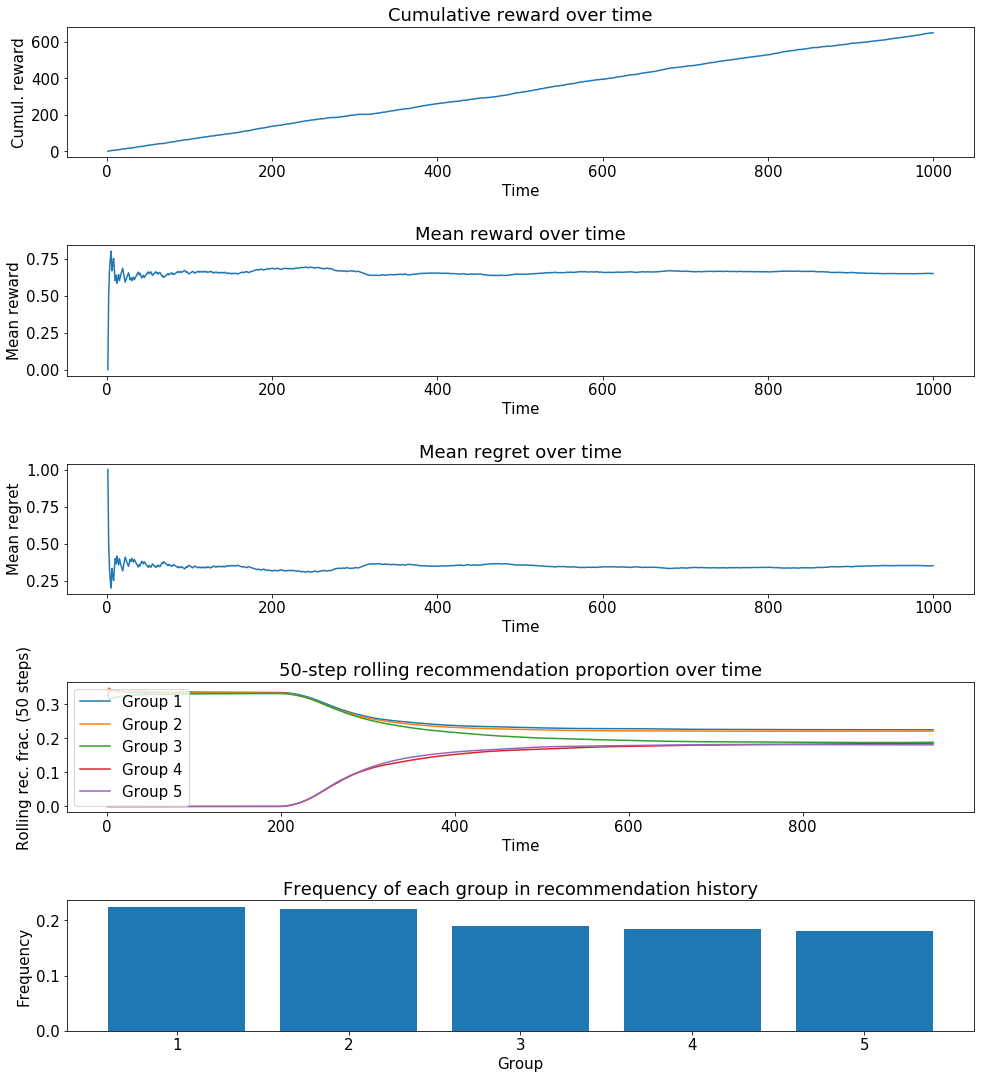

(0.04400000000000001, 649, 0.009020000000000004, 71.9512195121951)

In [70]:
# Initialize agent
SRVC = UCB_SRVC(multiplier = 1.0, window = 45, function = 3)

# Train agent
SRVC_history = train(user2, SRVC, steps = 1000)

# Plot results
score(SRVC_history)

## Using $f(N(k)) = N(k)$

Successfully trained UCB-SRVC Agent.
Group frequencies                        : [0.415 0.146 0.147 0.146 0.146]
Max gap between group frequencies        : 0.269
Cumulative gap between group frequencies : 0.28890999999999994
Total reward                             : 415/1000
Performance ratio                        : 1.4364334913987056


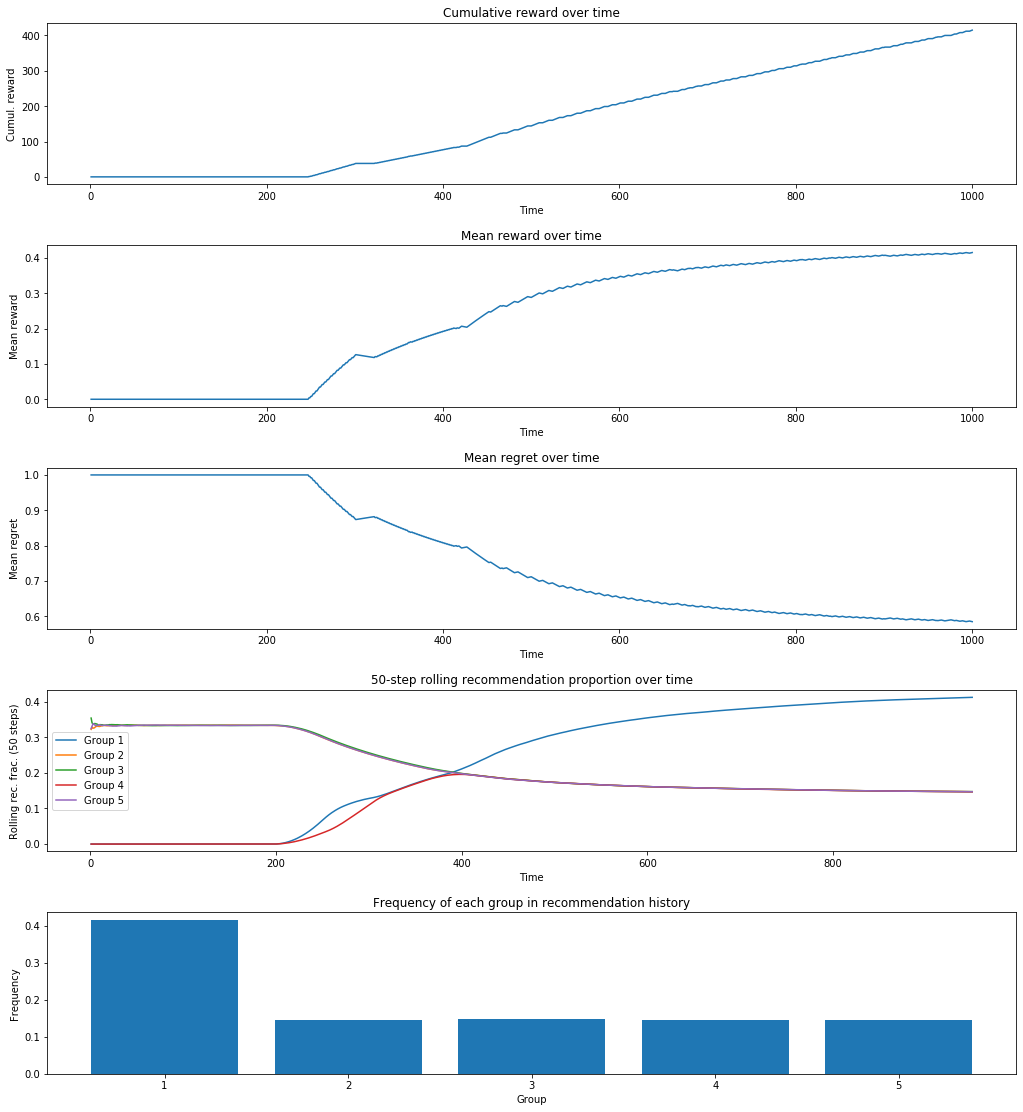

(0.269, 415, 0.28890999999999994, 1.4364334913987056)

In [26]:
# Initialize agent
SRVC = UCB_SRVC(multiplier = 1, window = 60, function = 2)

# Train agent
SRVC_history = train(user, SRVC, steps = 1000)

# Plot results
score(SRVC_history)

## Using $f(N(k)) = N(k)^2$

Successfully trained UCB-SRVC Agent.
Group frequencies                        : [0.001 0.498 0.499 0.001 0.001]
Max gap between group frequencies        : 0.498
Cumulative gap between group frequencies : 1.4850400000000001
Total reward                             : 1/1000
Performance ratio                        : 0.0006733825351505682


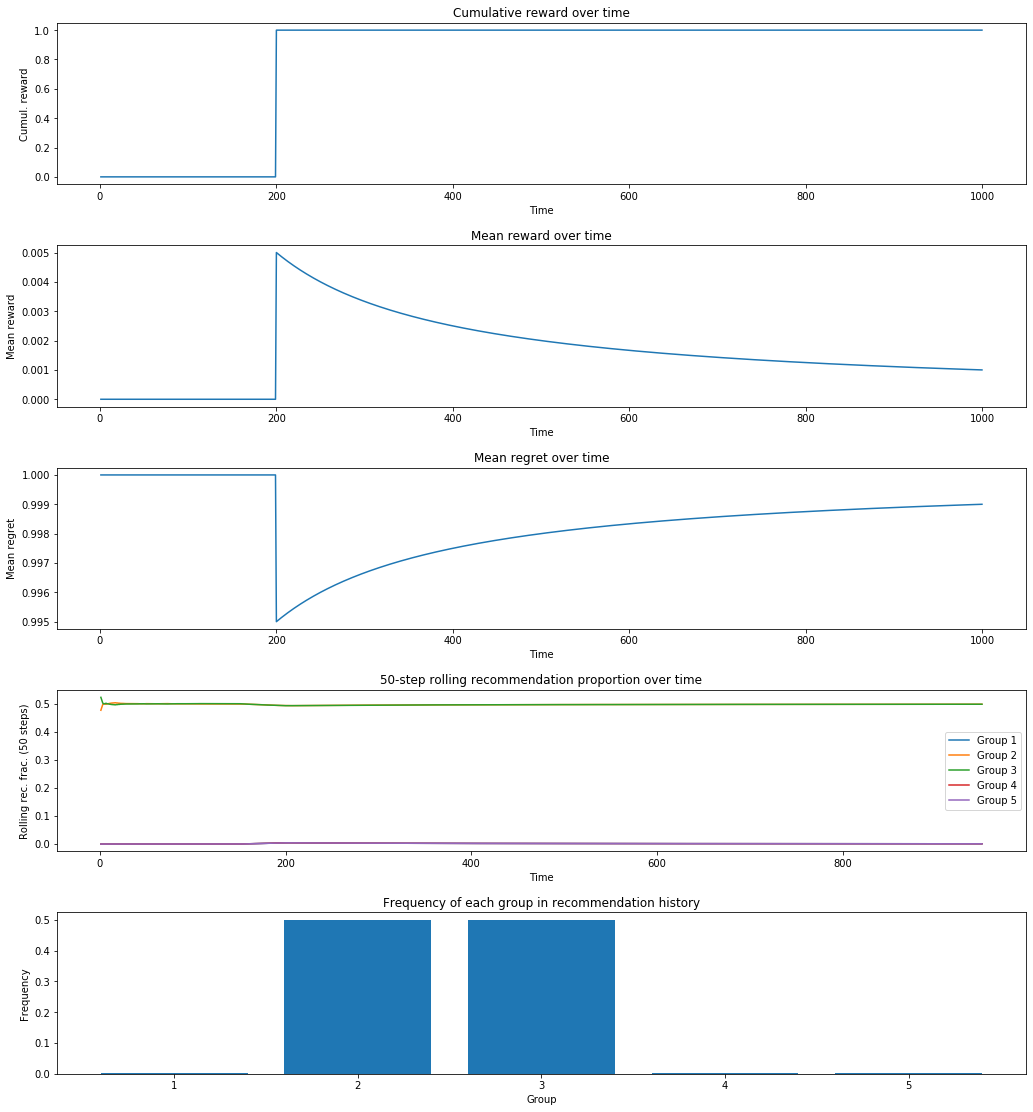

(0.498, 1, 1.4850400000000001, 0.0006733825351505682)

In [27]:
# Initialize agent
SRVC = UCB_SRVC(multiplier = 1, window = 50, function = 3)

# Train agent
SRVC_history = train(user, SRVC, steps = 1000)

# Plot results
score(SRVC_history)

# The MovieLens Dataset `[user_id, movie_id, genre, rating]`

In [28]:
import time

In [29]:
t0 = time.time()
movielens = getdata(binary_ratings = True)
t1 = time.time()
print('Data pre-processing took %3f seconds.' % (t1 - t0))

Data pre-processing took 12.368604 seconds.


## Data exploration

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter

# ------ Get Movie Genres: [movie_id, 19 movie genres] ------ #

f = open('../Data/u.item', 'r+', encoding = "ISO-8859-1")
movie_genres = np.zeros((1, 20))
indices = list(range(5, 24))
indices.insert(0, 0)
for l in f:
    line = l.strip().split("|")
    line = list(itemgetter(*indices)(line))
    movie_genres = np.vstack((movie_genres, list(map(int, line)))) 

movie_genres = movie_genres[1:].astype(int)    

In [31]:
# ------ Get User Ratings: [user_id, movie_id, rating] ------ #

f = open('../Data/u.data', 'r+')
movielens_raw = np.array([0, 0, 0, 0])
for l in f: 
    movielens_raw = np.vstack((movielens_raw, list(map(int, l.strip().split("\t")))))
movielens_raw = movielens_raw[1:, :3]


# ------ Merge Users, Movies, Ratings and Meta Genres: [user_id, movie_id, rating, 19 genres] ------ #

mv_original = np.zeros((1, 22))
for movie in movie_genres:
    movieID = movie[0]
    line    = movie[1:]
    data = movielens_raw[movielens_raw[:, 1] == movieID, :]
    n    = data.shape[0]
    line = np.tile(line, (n, 1))
    mv_original = np.vstack((mv_original, np.hstack((data, line))))
mv_original = mv_original[1:,]

original_counts = [sum(mv_original[:, i]) for i in range(3, 22)]

# ----- Group movies by meta-genre: [movie_id, meta genre] ----- #

meta_genres = { 1: [2, 3, 18],
                2: [4, 5],
                3: [6, 13],
                4: [7, 11, 17, 19, 14],
                5: [8],
                6: [9, 15],
                7: [10, 16],
                8: [12] }

meta_movie_genres = np.zeros((1, 2))

for g in meta_genres:
    data = movie_genres[:, meta_genres[g]]
    pos  = list(set(np.where(data == 1)[0]))
    temp = np.hstack((movie_genres[pos, 0].reshape((1, -1)).T, np.asarray([g] * len(pos)).reshape((1, -1)).T))
    meta_movie_genres = np.vstack((meta_movie_genres, temp))


# ------ Merge Users, Movies, Ratings and Meta Genres: [user_id, movie_id, rating, meta genre] ------ #

movielens = np.zeros((1, 4))
for movie in meta_movie_genres:
    movie_id, movie_genre = movie
    data = movielens_raw[movielens_raw[:, 1] == movie_id, :]
    n    = data.shape[0]
    cat  = np.asarray([movie_genre] * n).reshape((1, -1)).T
    movielens = np.vstack((movielens, np.hstack((data, cat))))
movielens = movielens[1:,]


# ----- Delete movies belonging to 'unknown' and 'documentary' genres ----- #

unknown_genre_ids = movie_genres[movie_genres[:, 1] > 0][:, 0]
ids               = np.where(np.in1d(movielens[:, 1], unknown_genre_ids) == True)[0]
movielens         = np.delete(movielens, np.s_[ids], axis = 0)

documentary_ids   = movie_genres[movie_genres[:, 8] > 0][:, 0]
ids               = np.where(np.in1d(movielens[:, 1], documentary_ids) == True)[0]
movielens         = np.delete(movielens, np.s_[ids], axis = 0)

movielens[movielens[:, -1] > 5, -1] -= 1


movielens[:, 2] = [1 if element >= 4 else 0 for element in movielens[:, 2]]


# Swap the 2 last columns to obtain final formatting: [user_id, movie_id, meta genre, rating]

movielens[:, [2, 3]] = movielens[:, [3, 2]]

counts2 = [movielens[movielens[:, -2] == i].shape[0] for i in set(movielens[:, -2])]

([<matplotlib.axis.XTick at 0x7ff85f45dac8>,
 <a list of 7 Text xticklabel objects>)

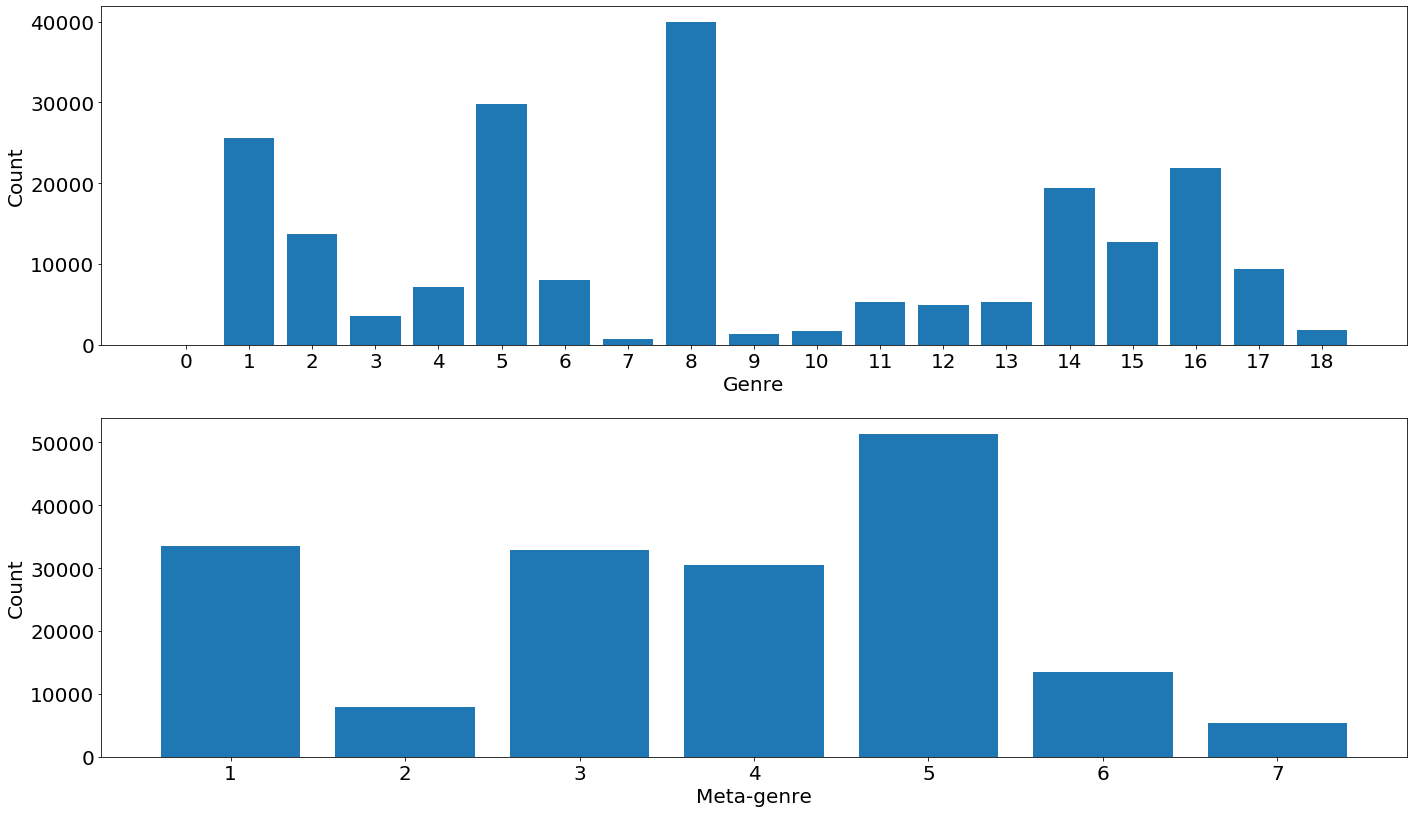

In [32]:
plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = [20, 12]

figure, _ = plt.subplots(2, 1)
figure.tight_layout(pad = 2.0)

plt.subplot(2, 1, 1)
plt.bar(range(0, 19), original_counts)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(list(range(0, 19)))
    
plt.subplot(2, 1, 2)
plt.bar(range(1, 8), counts2)
plt.xlabel('Meta-genre')
plt.ylabel('Count')
plt.xticks(list(range(1, 8)))

In [33]:
counts2

[33538, 7855, 32959, 30581, 51282, 13426, 5317]

In [34]:
original_counts

[10.0,
 25589.0,
 13753.0,
 3605.0,
 7182.0,
 29832.0,
 8055.0,
 758.0,
 39895.0,
 1352.0,
 1733.0,
 5317.0,
 4954.0,
 5245.0,
 19461.0,
 12730.0,
 21872.0,
 9398.0,
 1854.0]

In [35]:
gaps = like_gaps(movielens)

In [36]:
counts = user_counts(movielens)

In [95]:
# Number of arms:
arms = 7

# Fairness constraints
c = [.1, .1, .1, .1, .1, .1, .1]

Total number of items in dataset : 174958
Meta genres proportion of ratings : [0.19, 0.04, 0.19, 0.17, 0.29, 0.08, 0.03]
Meta genres proportion of likes   : [0.55, 0.49, 0.5, 0.56, 0.6, 0.55, 0.47]


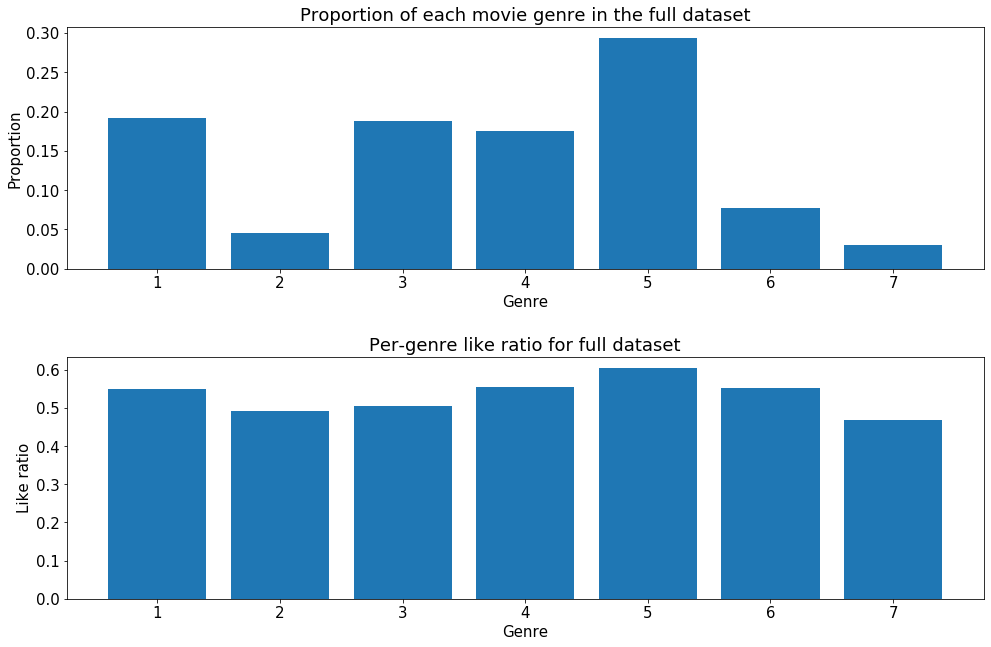

In [38]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams.update({'font.size': 15})
dataset_stats(movielens)

Total number of items rated by user 833 : 457
Total number of items liked by user 833 : 175.0
Meta genres proportion of ratings : [0.19, 0.01, 0.15, 0.23, 0.25, 0.11, 0.07]
Meta genres proportion of likes   : [0.34, 1.0, 0.27, 0.45, 0.43, 0.35, 0.35]


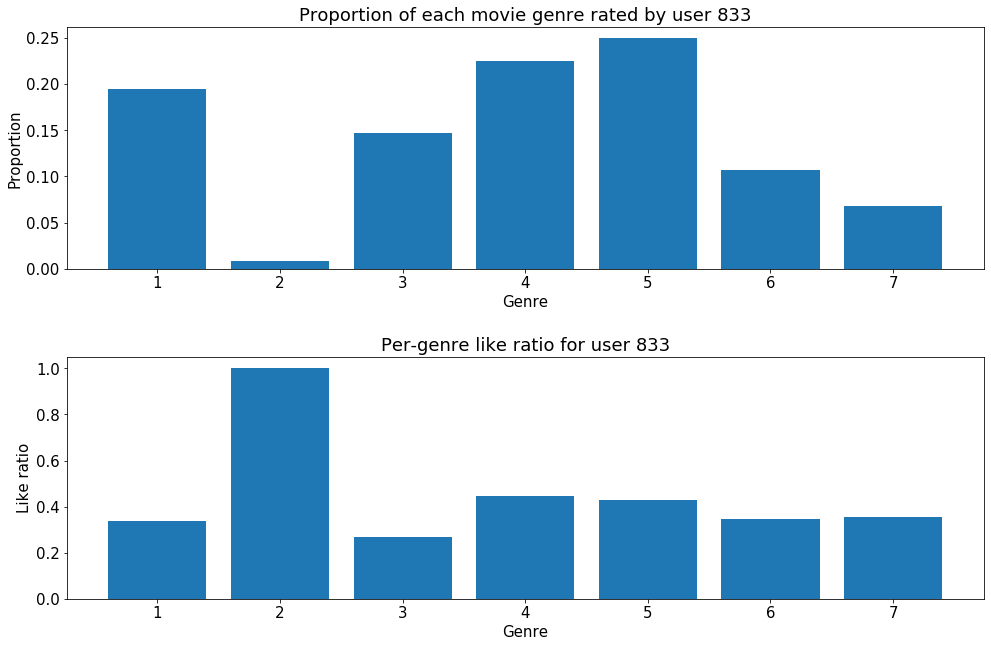

In [39]:
k = 833
user = get_user(movielens, k)

In [122]:
# Set number of learning steps
rounds = 200

In [123]:
# Initialise agents
rdm  = RandomBandit(n_arms = arms)
eps  = EpsilonGreedy(number_of_arms = arms, epsilon = param_epsilon)
ucb  = UCB(number_of_arms = arms, bonus_multiplier = param_multiplier)
th   = Thompson(number_of_arms = arms)

# Train agents
history_rdm  = train(user,  rdm, steps = rounds)
history_eps  = train(user,  eps, steps = rounds)
history_ucb  = train(user,  ucb, steps = rounds)
history_th   = train(user,   th, steps = rounds)

Successfully trained Random Agent.
Successfully trained Epsilon Greedy Agent.
Successfully trained UCB Agent.
Successfully trained Thompson Sampling Agent.


In [124]:
plt.rcParams['figure.figsize'] = [15, 16]

### Random Agent

Group frequencies                        : [0.175 0.1   0.175 0.145 0.13  0.155 0.12 ]
Max gap between group frequencies        : 0.07499999999999998
Cumulative gap between group frequencies : 0.03319999999999999
Total reward                             : 79/200
Performance ratio                        : 11.897590361445785


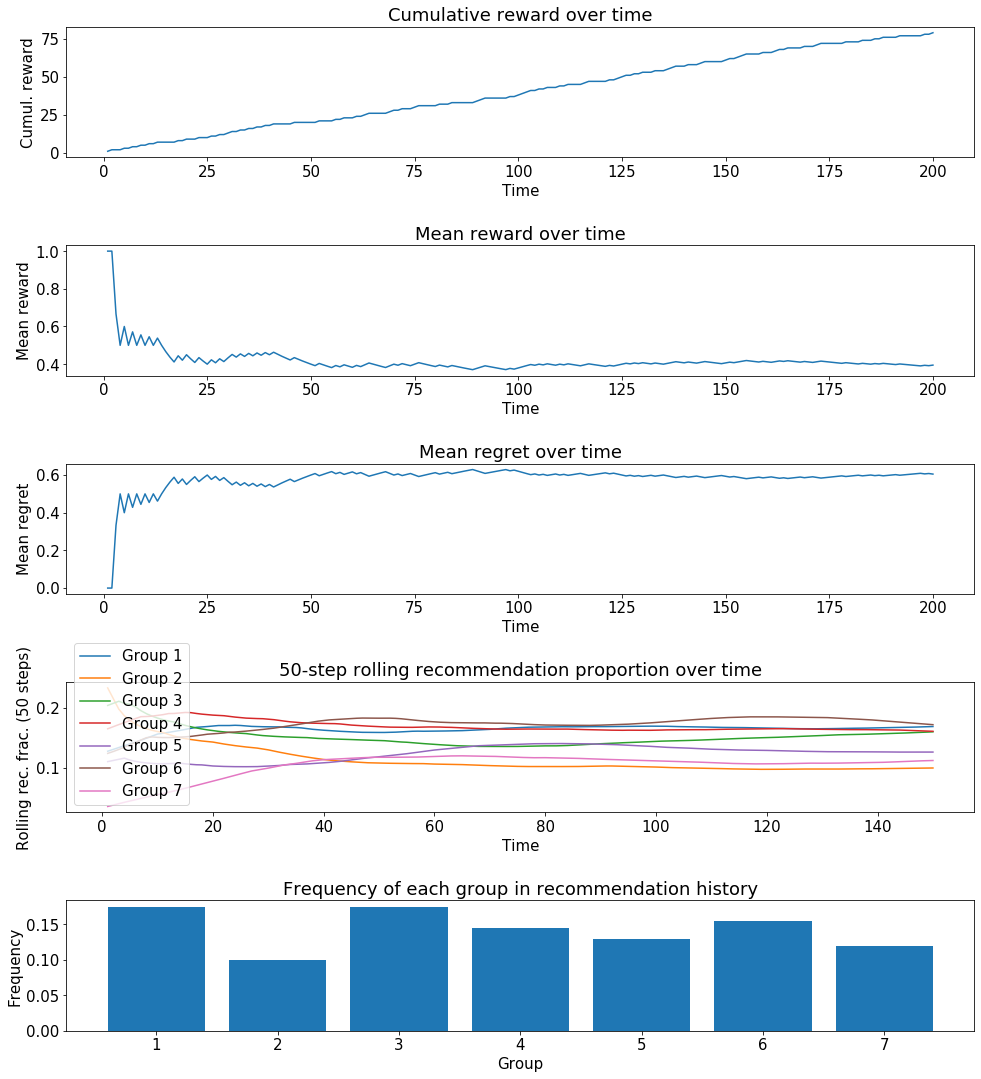

(0.07499999999999998, 79, 0.03319999999999999, 11.897590361445785)

In [125]:
score(history_rdm)

### $\epsilon$-Greedy

Group frequencies                        : [0.01  0.455 0.005 0.01  0.015 0.415 0.09 ]
Max gap between group frequencies        : 0.45
Cumulative gap between group frequencies : 1.7146
Total reward                             : 124/200
Performance ratio                        : 0.36160037326490146


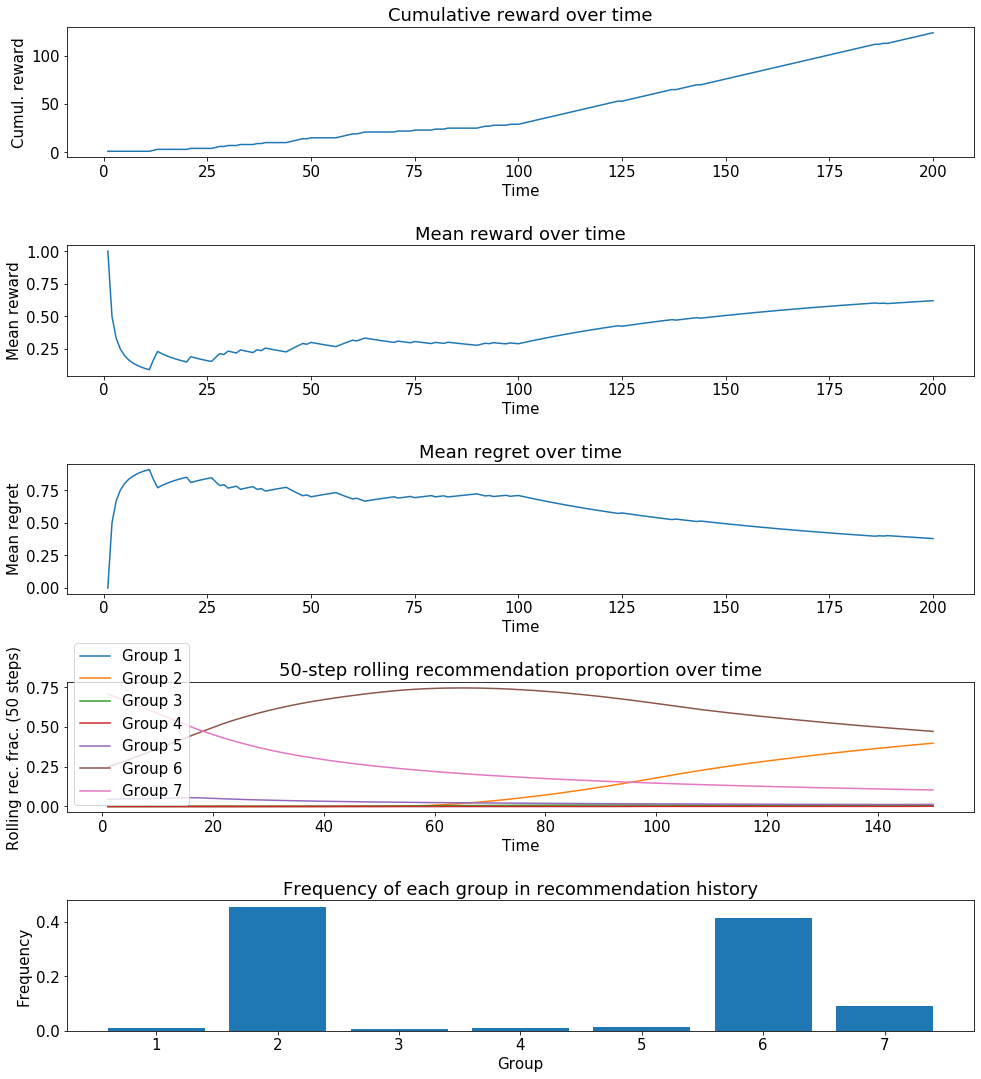

(0.45, 124, 1.7146, 0.36160037326490146)

In [126]:
score(history_eps)

### UCB

Group frequencies                        : [0.05 0.69 0.03 0.08 0.08 0.03 0.04]
Max gap between group frequencies        : 0.6599999999999999
Cumulative gap between group frequencies : 2.4635999999999996
Total reward                             : 158/200
Performance ratio                        : 0.3206689397629486


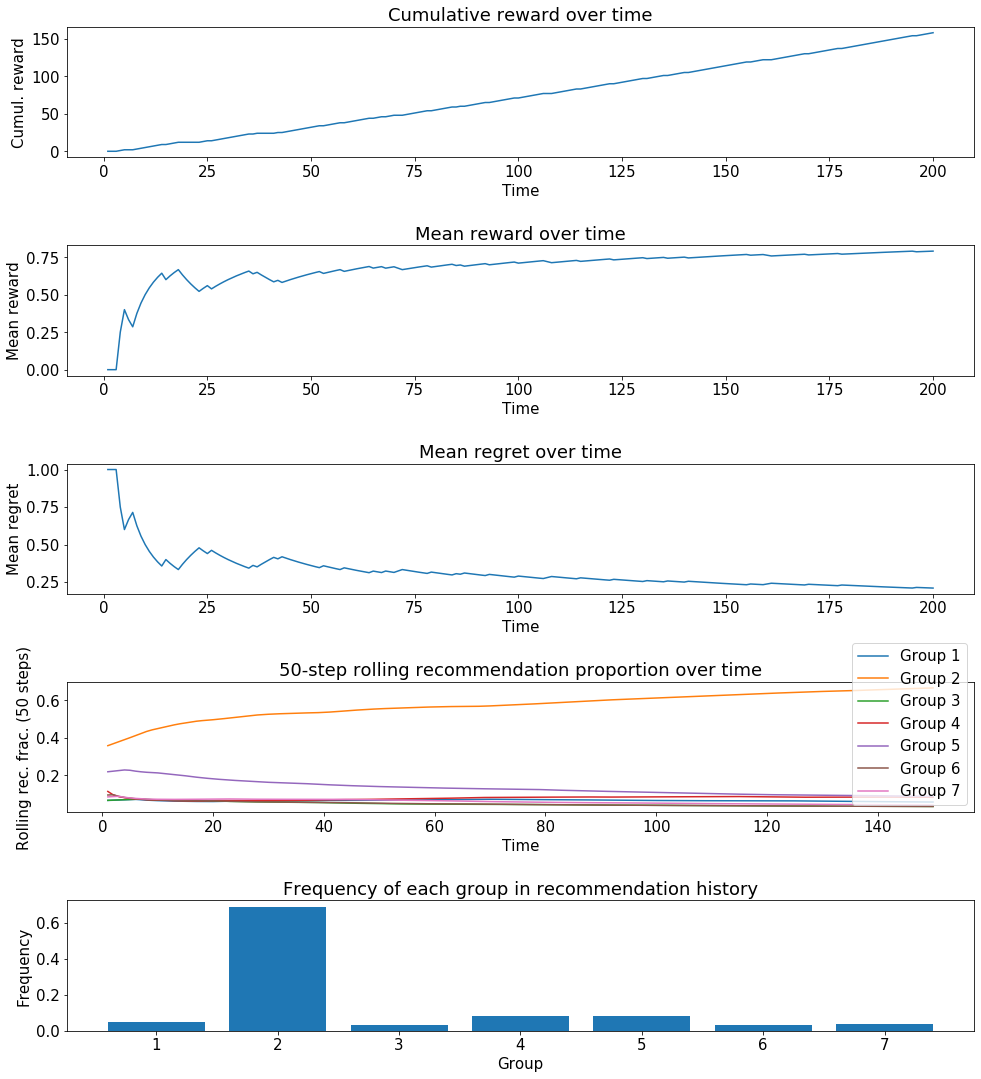

(0.6599999999999999, 158, 2.4635999999999996, 0.3206689397629486)

In [127]:
score(history_ucb)

### Thompson Sampling

Group frequencies                        : [0.03  0.92  0.005 0.015 0.01  0.01  0.01 ]
Max gap between group frequencies        : 0.915
Cumulative gap between group frequencies : 4.93495
Total reward                             : 192/200
Performance ratio                        : 0.19453084631049963


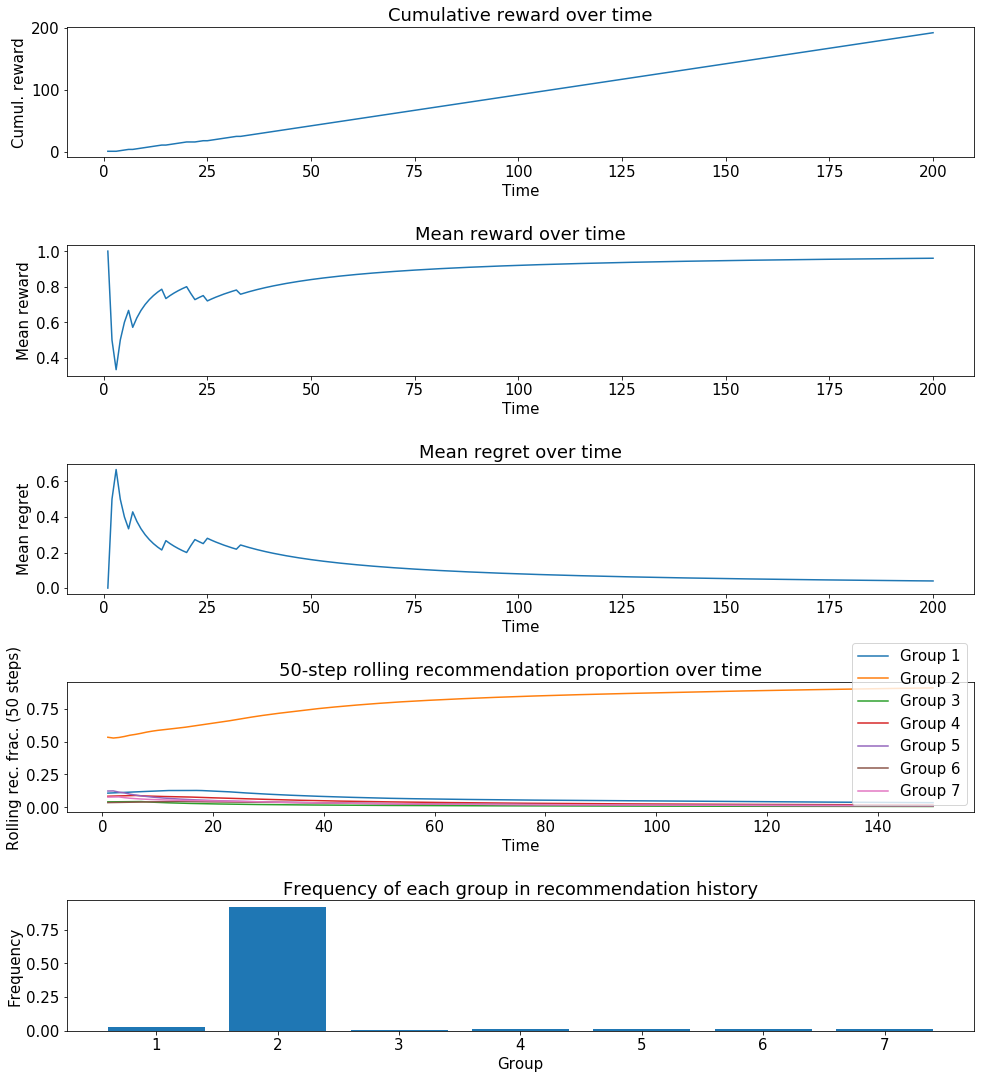

(0.915, 192, 4.93495, 0.19453084631049963)

In [128]:
score(history_th)

# Depolarised MovieLens

In [129]:
# Initialise agents
eps = FairEG(number_of_arms = arms, epsilon = param_epsilon, constraints = c)
ucb = FairMAB_UCB(number_of_arms = arms, bonus_multiplier = param_multiplier, constraints = c)
th  = FairThompson(number_of_arms = arms, constraints = c)
ucb_srvc = UCB_SRVC(number_of_arms = arms, multiplier = 1, window = 20, function = 3)

# Train agents
history_eps = train(user, eps, steps = rounds)
history_ucb = train(user, ucb, steps = rounds)
history_th  = train(user,  th, steps = rounds)
history_ucb_srvc = train(user, ucb_srvc, steps = rounds)

Successfully trained Fair Epsilon Greedy agent.
Successfully trained Fair UCB agent.
Successfully trained Fair Thompson Sampling agent.
Successfully trained UCB-SRVC Agent.


### Fair $\epsilon$-Greedy

Group frequencies                        : [0.1   0.395 0.1   0.1   0.1   0.1   0.105]
Max gap between group frequencies        : 0.29500000000000004
Cumulative gap between group frequencies : 0.5193500000000003
Total reward                             : 115/200
Performance ratio                        : 1.1071531722345234


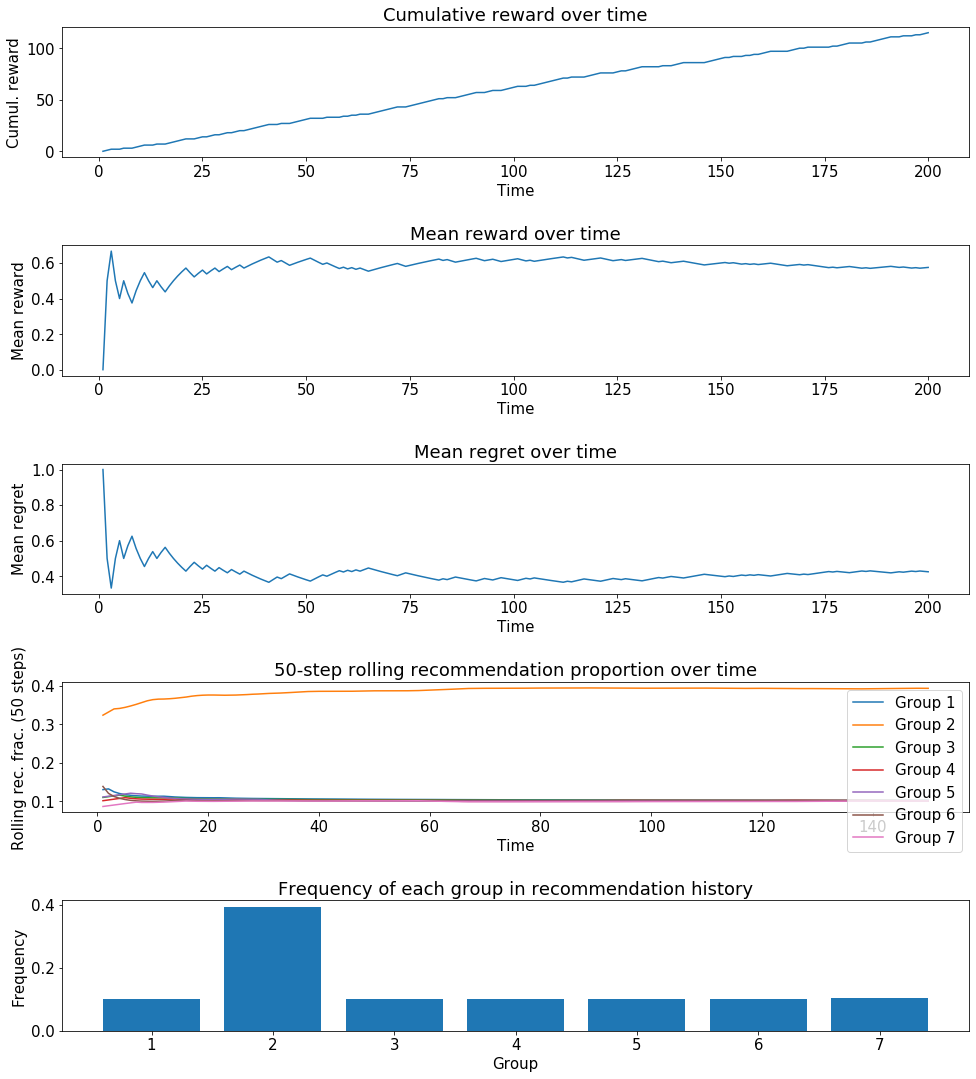

(0.29500000000000004, 115, 0.5193500000000003, 1.1071531722345234)

In [130]:
score(history_eps)

### Fair-UCB

Group frequencies                        : [0.095 0.43  0.095 0.095 0.095 0.095 0.095]
Max gap between group frequencies        : 0.33499999999999996
Cumulative gap between group frequencies : 0.6733499999999999
Total reward                             : 131/200
Performance ratio                        : 0.9727481993019975


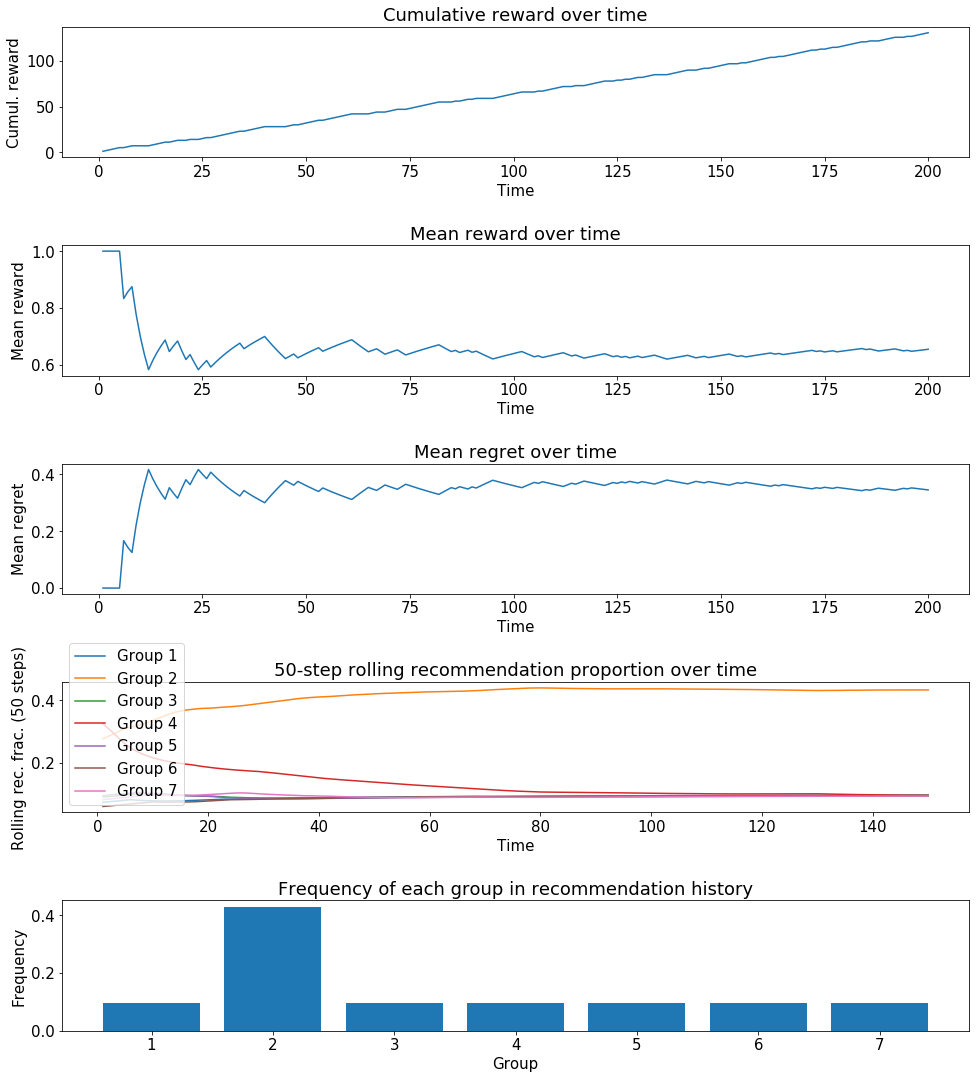

(0.33499999999999996, 131, 0.6733499999999999, 0.9727481993019975)

In [131]:
score(history_ucb)

### Fair-Thompson

Group frequencies                        : [0.1 0.4 0.1 0.1 0.1 0.1 0.1]
Max gap between group frequencies        : 0.30000000000000004
Cumulative gap between group frequencies : 0.5400000000000001
Total reward                             : 120/200
Performance ratio                        : 1.1111111111111107


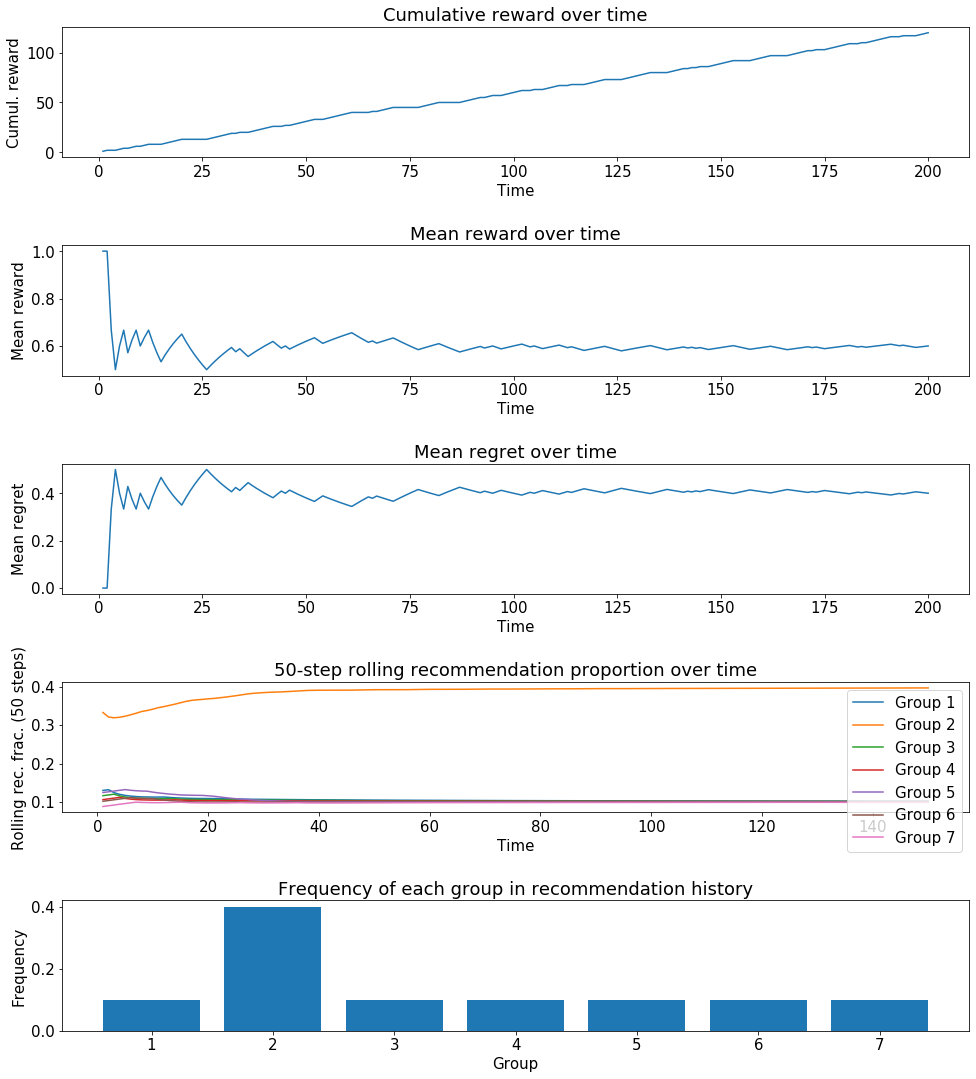

(0.30000000000000004, 120, 0.5400000000000001, 1.1111111111111107)

In [132]:
score(history_th)

### UCB-SRVC

Successfully trained UCB-SRVC Agent.
Group frequencies                        : [0.495 0.    0.    0.    0.005 0.    0.5  ]
Max gap between group frequencies        : 0.5
Cumulative gap between group frequencies : 2.4653499999999995
Total reward                             : 68/200
Performance ratio                        : 0.13791145273490582


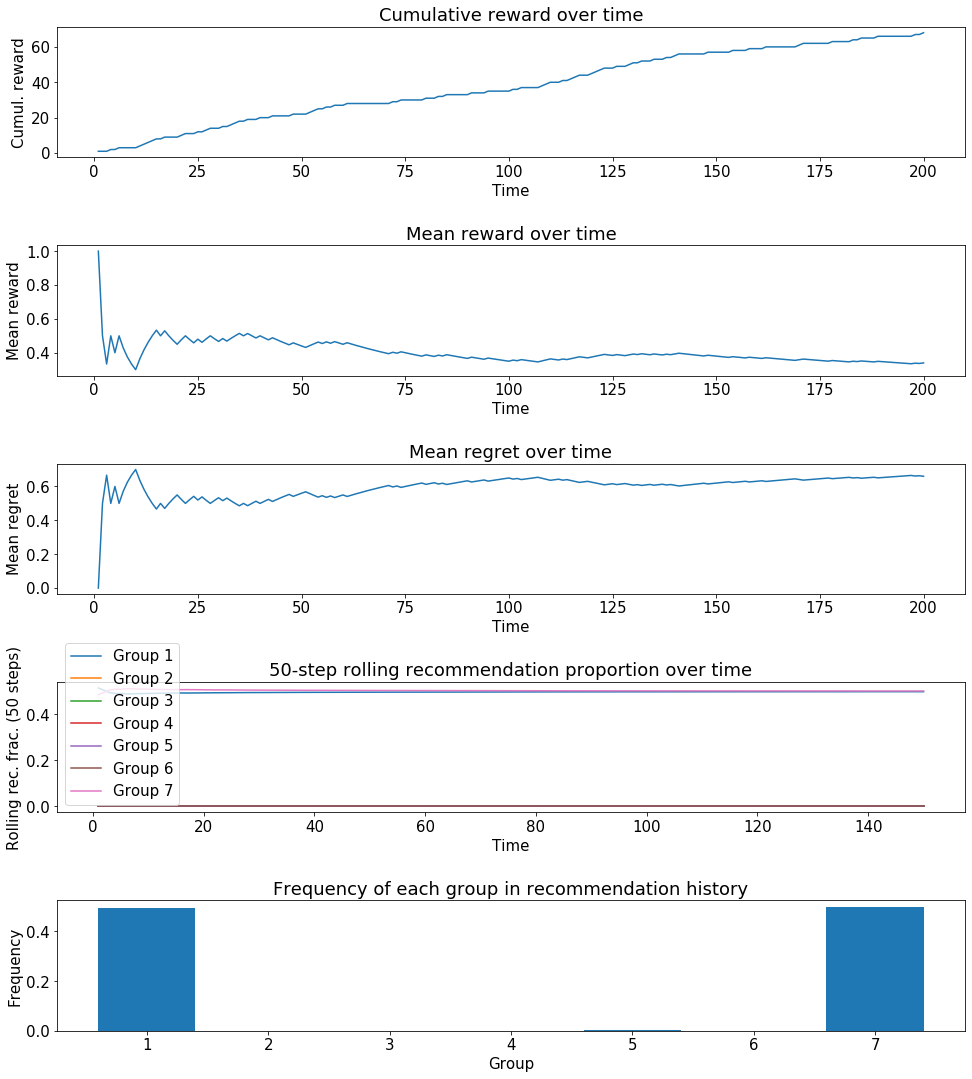

(0.5, 68, 2.4653499999999995, 0.13791145273490582)

In [165]:
ucb_srvc = UCB_SRVC(number_of_arms = arms, multiplier = 2.0, window = 65, function = 2)
history_ucb_srvc = train(user, ucb_srvc, steps = rounds)
score(history_ucb_srvc)